In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import transformers
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import sys
sys.path.append('/content/drive/MyDrive/skripsi')
!ls /content/drive/MyDrive/skripsi


 app.py						   finetuning_RoBERTa3.ipynb
 check_lang.py					   finetuning_RoBERTa.ipynb
 cluster_sinta2.ipynb				   functions.py
 cluster_sinta3.ipynb				   model
 cluster_sinta.ipynb				   predict_multibert_kmeans_finetuned.ipynb
'Copy of cluster_sinta3.ipynb'			   predict_RoBERTa_kmeans_finetuned.ipynb
'Copy of predict_RoBERTa_kmeans_finetuned.ipynb'   Preprocessing_data_sinta.ipynb
'Copy of Untitled0.ipynb'			   Preprocessing.py
 data						   __pycache__
 finetuned_multibert2.ipynb			   src
 finetuned_pipeline.py				   Untitled0.ipynb
 finetuning_RoBERTa2.ipynb			   Untitled1.ipynb


In [ ]:
from Preprocessing import preprocess_text

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/skripsi/data/data_sinta_cleaned3.csv')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df

,jid,desc,title,date,journal,data_cleaned,eissn,jid_umum
0,1,Belakangan ini Lembaga PAUD berbondong-bondong...,Kemampuan Bahasa Inggris Awal pada Periode Lin...,2023-10-05,JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI,kemampuan bahasa inggris awal pada periode lin...,2549-8959,1
1,1,The assessment process carried out in schools ...,Strengthening Early Childhood Learning Outcome...,2022-06-09,JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI,strengthening early childhood learning outcome...,2549-8959,1
2,1,Kewajiban guru PAUD untuk memberikan layanan b...,Eksplorasi Deskriptif tentang Layanan Bimbinga...,2023-06-07,JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI,eksplorasi deskriptif tentang layanan bimbinga...,2549-8959,1
3,1,Pandemi Covid-19 merambah sejak awal tahun 202...,Perspektif Orang Tua terhadap Pelaksanaan Les ...,2021-06-02,JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI,perspektif orang tua terhadap pelaksanaan les ...,2549-8959,1
4,1,Dalam upaya mencapai Sustainable Development G...,Strategi Pencegahan dan Penanganan Stunting Mu...,2023-12-26,JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI,strategi pencegahan dan penanganan stunting mu...,2549-8959,1
...,...,...,...,...,...,...,...,...
8670,12,The purpose of this study to examine the effec...,"PENGARUH KINERJA KEUANGAN, DANA ALOKASI UMUM D...",2017-05-15,E-JURNAL AKUNTANSI,pengaruh kinerja keuangan dana alokasi umum da...,2302-8556,12
8671,12,The level of understanding of accounting to be...,"PENGARUH KECERDASAN EMOSIONAL, KECERDASAN INTE...",2017-08-06,E-JURNAL AKUNTANSI,pengaruh kecerdasan emosional kecerdasan intel...,2302-8556,12
8672,12,The purpose of this study was to examine the i...,"PENGARUH UKURAN PERUSAHAAN, KOMPLEKSITAS OPERA...",2017-02-15,E-JURNAL AKUNTANSI,pengaruh ukuran perusahaan kompleksitas operas...,2302-8556,12
8673,12,The purpose of this study is to determine the ...,KINERJA DINAS PARIWISATA BALI BERDASARKAN KONS...,2016-11-10,E-JURNAL AKUNTANSI,kinerja dinas pariwisata bali berdasarkan kons...,2302-8556,12


In [ ]:
df[df.data_cleaned.isna()]

,jid,desc,title,date,journal,data_cleaned,eissn,jid_umum


In [ ]:
title_unik = list(df.journal.unique())
title_unik

['JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI',
 'JURNAL CENDEKIA : JURNAL PENDIDIKAN MATEMATIKA',
 'INTERNATIONAL JOURNAL OF ELEMENTARY EDUCATION',
 'JURNAL BISNIS DAN AKUNTANSI',
 'JURNAL AKUNTANSI DAN KEUANGAN',
 'JURNAL PENDIDIKAN TEKNIK MESIN UNDIKSHA',
 'INTERNATIONAL JOURNAL OF BASIC AND APPLIED SCIENCE',
 'JURNAL KESEHATAN MASYARAKAT',
 'GADJAH MADA INTERNATIONAL JOURNAL OF BUSINESS',
 'JURNAL KESEHATAN ANDALAS',
 'E-JOURNAL OF CULTURAL STUDIES',
 'E-JURNAL AKUNTANSI']

In [ ]:
df.data_cleaned[0]

'kemampuan bahasa inggris awal pada periode linguistik anak usia dini belakangan ini lembaga paud berbondongbondong memberikan pembelajaran bahasa inggris bagi anak diperiode linguistik penelitian ini bertujuan untuk mengetahui kemampuan awal anak dalam mendengarkan dan mengucapkan kosakata bahasa inggris pada periode linguistic penelitian ini merupakan penelitian deskriptif dengan menggunakan pendekatan kuantitatif populasi penelitian ini mencakup anak pada taman kanakkanak selanjutnya peneliti melakukan penarikan sampling dengan teknik sampling jenuh dengan jumlah  anak penelitian ini dilakukan pada bulan september   maret  dengan bekerjasama dengan guru kelas kegiatan pengumpulan data penelitian ini dilakukan melalui observasi dengan model partisipatif adapun deskripsi hasil penelitian ini dibagi menjadi dua yakni kemampuan mendengarkan kosakata bahasa inggris awal yakni dengan kategori mulai berkembang selanjutnya kemampuan mengucapkan kosakata bahasa inggris awal berada pada kateg

In [ ]:
df['jid_umum'] = df['jid']
df['jid_umum'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
journal_id = {title_unik[i] : i + 1 for i in range(len(title_unik))}
df['jid'] = df.journal.apply(lambda x : journal_id[x])
df

,jid,desc,title,date,journal,data_cleaned,eissn,jid_umum
0,1,Belakangan ini Lembaga PAUD berbondong-bondong...,Kemampuan Bahasa Inggris Awal pada Periode Lin...,2023-10-05,JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI,kemampuan bahasa inggris awal pada periode lin...,2549-8959,1
1,1,The assessment process carried out in schools ...,Strengthening Early Childhood Learning Outcome...,2022-06-09,JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI,strengthening early childhood learning outcome...,2549-8959,1
2,1,Kewajiban guru PAUD untuk memberikan layanan b...,Eksplorasi Deskriptif tentang Layanan Bimbinga...,2023-06-07,JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI,eksplorasi deskriptif tentang layanan bimbinga...,2549-8959,1
3,1,Pandemi Covid-19 merambah sejak awal tahun 202...,Perspektif Orang Tua terhadap Pelaksanaan Les ...,2021-06-02,JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI,perspektif orang tua terhadap pelaksanaan les ...,2549-8959,1
4,1,Dalam upaya mencapai Sustainable Development G...,Strategi Pencegahan dan Penanganan Stunting Mu...,2023-12-26,JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI,strategi pencegahan dan penanganan stunting mu...,2549-8959,1
...,...,...,...,...,...,...,...,...
8670,12,The purpose of this study to examine the effec...,"PENGARUH KINERJA KEUANGAN, DANA ALOKASI UMUM D...",2017-05-15,E-JURNAL AKUNTANSI,pengaruh kinerja keuangan dana alokasi umum da...,2302-8556,12
8671,12,The level of understanding of accounting to be...,"PENGARUH KECERDASAN EMOSIONAL, KECERDASAN INTE...",2017-08-06,E-JURNAL AKUNTANSI,pengaruh kecerdasan emosional kecerdasan intel...,2302-8556,12
8672,12,The purpose of this study was to examine the i...,"PENGARUH UKURAN PERUSAHAAN, KOMPLEKSITAS OPERA...",2017-02-15,E-JURNAL AKUNTANSI,pengaruh ukuran perusahaan kompleksitas operas...,2302-8556,12
8673,12,The purpose of this study is to determine the ...,KINERJA DINAS PARIWISATA BALI BERDASARKAN KONS...,2016-11-10,E-JURNAL AKUNTANSI,kinerja dinas pariwisata bali berdasarkan kons...,2302-8556,12


In [ ]:
df.to_csv('/content/drive/MyDrive/skripsi/data/data_sinta_cleaned3.csv', index=False)

In [ ]:
'''
1 'JURNAL OBSESI: JURNAL PENDIDIKAN ANAK USIA DINI',
2 'JURNAL CENDEKIA : JURNAL PENDIDIKAN MATEMATIKA',
3 'INTERNATIONAL JOURNAL OF ELEMENTARY EDUCATION',
4 'JURNAL BISNIS DAN AKUNTANSI',
5 'JURNAL AKUNTANSI DAN KEUANGAN',
6 'JURNAL PENDIDIKAN TEKNIK MESIN UNDIKSHA',
7 'INTERNATIONAL JOURNAL OF BASIC AND APPLIED SCIENCE',
8 'JURNAL KESEHATAN MASYARAKAT',
9 'GADJAH MADA INTERNATIONAL JOURNAL OF BUSINESS',
10 'JURNAL KESEHATAN ANDALAS',
11 'E-JOURNAL OF CULTURAL STUDIES',
12 'E-JURNAL AKUNTANSI'
 '''


jurnal_id = 1


data_jid = df[df['jid']==jurnal_id]
data = data_jid['data_cleaned']
data

,data_cleaned
0,kemampuan bahasa inggris awal pada periode lin...
1,strengthening early childhood learning outcome...
2,eksplorasi deskriptif tentang layanan bimbinga...
3,perspektif orang tua terhadap pelaksanaan les ...
4,strategi pencegahan dan penanganan stunting mu...
...,...
1464,pencapaian perkembangan anak usia dini di tama...
1465,colour ball based on microcontroller as a educ...
1466,pengembangan teknologi digital cerita sains te...
1467,pengaruh bimtek guru pembimbing khusus terhada...


In [ ]:
class RobertaClassifier(nn.Module):
    def __init__(self, num_labels):
        super(RobertaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.classifier = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs['last_hidden_state']
        # x = self.classifier(x)
        return x

In [ ]:
# Load pre-trained RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaClassifier(12)
model.load_state_dict(torch.load('/content/drive/MyDrive/skripsi/model/finetuned_model_roberta3.pt'))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
def tokenize_data(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            pad_to_max_length=True,
                            return_attention_mask=True,
                            return_tensors='pt'
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Tokenize data
input_ids, attention_masks = tokenize_data(data, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Create dataloader
class ArticleDataset(Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids = input_ids
        self.attention_masks = attention_masks

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx]
        }

    def __len__(self):
        return len(self.input_ids)

dataset = ArticleDataset(input_ids, attention_masks)


In [ ]:
# Create dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

model.to(device)

# Set model to evaluation mode
model.eval()

RobertaClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
# Embedding
embeddings = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        embeddings.append(outputs.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)

In [ ]:
embeddings.shape

(1469, 128, 768)

In [ ]:
embeddings[0][0]

array([ 1.23403561e+00,  1.01779139e+00,  4.26087320e-01, -5.99910438e-01,
        6.64480984e-01, -2.56899047e+00,  7.49779820e-01,  9.18821633e-01,
       -7.02672541e-01,  7.90182590e-01, -1.00123250e+00, -1.21075809e+00,
       -2.77516823e-02, -5.29252827e-01,  2.80066997e-01, -1.17970645e+00,
       -9.52779472e-01,  2.27648437e-01, -6.72499061e-01, -4.23830867e-01,
        2.02610403e-01, -4.65502620e-01,  4.30165917e-01,  1.61578786e+00,
       -3.74300778e-01,  6.94424689e-01,  6.10286713e-01, -4.48639065e-01,
        3.20791483e-01,  4.91590440e-01, -1.43837416e+00,  1.57407761e-01,
        1.57301977e-01,  6.64121628e-01, -5.78664243e-01,  2.50722110e-01,
        3.99284028e-02, -5.78637719e-02, -7.53799617e-01, -5.91877103e-01,
        2.35589504e+00,  6.38225615e-01,  4.35148180e-02,  5.67160785e-01,
       -5.12719691e-01, -7.89658129e-01,  1.70293748e-01, -5.97165644e-01,
        3.25357877e-02,  9.99962449e-01, -1.07520990e-01, -6.20456755e-01,
       -3.99902225e-01,  

In [ ]:
# Mengubah array embeddings menjadi matriks dua dimensi
X = embeddings.reshape(embeddings.shape[0], -1)

pca = PCA(n_components=2, random_state=0)
X = pca.fit_transform(X)

In [ ]:
# Perform KMeans clustering
num_clusters = 1
kmeans = KMeans(n_clusters=num_clusters, random_state=0, max_iter=1000)
kmeans.fit(X)

# Assign each journal to its cluster
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


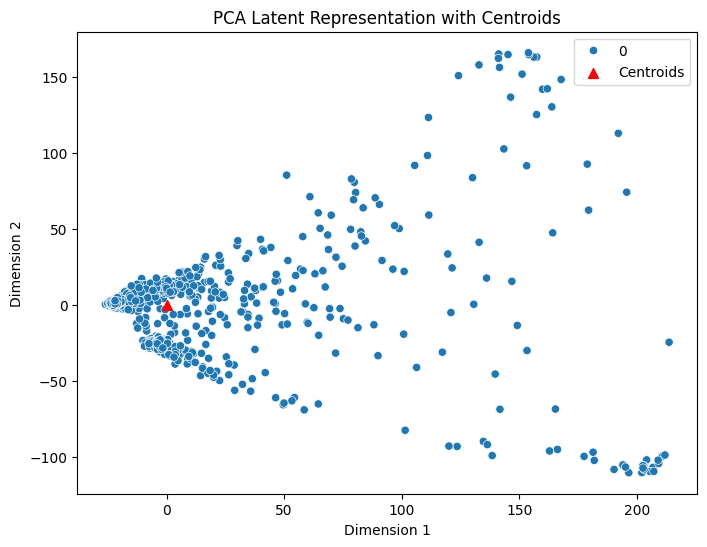

In [ ]:
def plot_vector_distribution(vector_representation, kmeans_labels):
    # pca = PCA(n_components=2, random_state=0)
    # pca_result = pca.fit_transform(vector_representation)

    # df_pca = pd.DataFrame(pca_result, columns=['Dimension 1', 'Dimension 2'])
    df_pca = pd.DataFrame(vector_representation, columns=['Dimension 1', 'Dimension 2'])
    df_pca['Cluster Label'] = kmeans_labels

    cluster_palette = sns.color_palette('tab10', n_colors=len(np.unique(kmeans_labels)))
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cluster Label', data=df_pca, palette=cluster_palette)

    # Menambahkan centroid ke dalam plot
    centroids = []
    for label in np.unique(kmeans_labels):
        # centroid = np.mean(pca_result[kmeans_labels == label], axis=0)
        centroid = np.mean(vector_representation[kmeans_labels == label], axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', c='red', s=50, label='Centroids')

    plt.title('PCA Latent Representation with Centroids')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

plot_vector_distribution(X, cluster_labels)

In [ ]:
# Mendapatkan koordinat pusat cluster
centroid = kmeans.cluster_centers_

# Menghitung jarak antara setiap titik data dengan centroid
jarak_ke_centroid = np.sqrt(np.sum((X - centroid)**2, axis=1))

# Menentukan batas jarak yang dianggap sebagai "outscoop"
outscoop_threshold = np.mean(jarak_ke_centroid) + 2 * np.std(jarak_ke_centroid)

# Memisahkan data yang masih masuk dalam "scoop" dan "outscoop"
scoop_data = X[jarak_ke_centroid <= outscoop_threshold]
outscoop_data = X[jarak_ke_centroid > outscoop_threshold]

print(outscoop_threshold)

113.10079574584961


<ipython-input-24-f9d194638d11>:10: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Scoop Label', style='Scoop Label', data=df_pca, palette=cluster_palette, markers=['o', 'X'], legend='full')


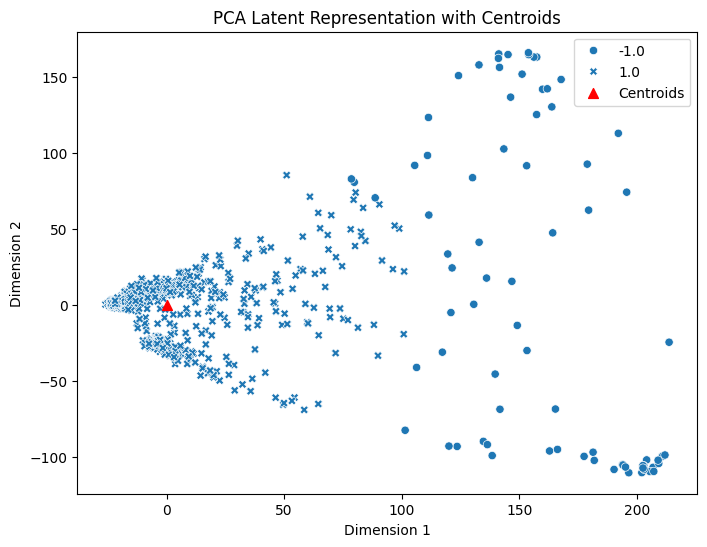

In [ ]:
def plot_vector_distribution(vector_representation, kmeans_labels, scoop_labels, new_data_pca=None):
    pca = PCA(n_components=2, random_state=0)
    pca_result = pca.fit_transform(vector_representation)

    df_pca = pd.DataFrame(pca_result, columns=['Dimension 1', 'Dimension 2'])
    df_pca['Scoop Label'] = scoop_labels

    cluster_palette = sns.color_palette('tab10', n_colors=len(np.unique(kmeans_labels)))
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Scoop Label', style='Scoop Label', data=df_pca, palette=cluster_palette, markers=['o', 'X'], legend='full')

    # Menambahkan centroid ke dalam plot
    centroids = []
    for label in np.unique(kmeans_labels):
        centroid = np.mean(pca_result[kmeans_labels == label], axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', c='red', s=50, label='Centroids')

    # Menampilkan posisi data PCA baru
    if new_data_pca is not None:
        plt.scatter(new_data_pca[:, 0], new_data_pca[:, 1], marker='s', c='black', s=50, label='New Data PCA')

    plt.title('PCA Latent Representation with Centroids')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

    return df_pca

# Menentukan label untuk scoop dan outscoop
scoop_labels = np.ones(len(X))
scoop_labels[jarak_ke_centroid > outscoop_threshold] = -1

df_pca = plot_vector_distribution(X, kmeans.labels_, scoop_labels)

In [ ]:
journal_type = 'finetuning_sinta'

# Assuming 'jurnal_id' is a variable containing the directory name
file_path = f"/content/drive/MyDrive/skripsi/src/{journal_type}/{jurnal_id}"

if not os.path.exists(file_path):
  os.mkdir(file_path)

In [ ]:
import numpy as np
import joblib

# Simpan model KMeans
filename_kmeans = f"{file_path}/{jurnal_id}_kmeans.pkl"
joblib.dump(kmeans, filename_kmeans)
print("Model KMeans telah disimpan dengan nama:", filename_kmeans)

# Simpan threshold
np.save(f"{file_path}/{jurnal_id}_threshold.npy", outscoop_threshold)
print("Threshold telah disimpan.")

# Simpan data sebaran PCA
np.save(f"{file_path}/{jurnal_id}_pca_data.npy", X)
print("Data sebaran PCA telah disimpan.")

# Simpan data sebaran multibert
np.save(f"{file_path}/{jurnal_id}_bert_data.npy", embeddings.reshape(embeddings.shape[0], -1))
print("Data sebaran PCA telah disimpan.")


Model KMeans telah disimpan dengan nama: /content/drive/MyDrive/skripsi/src/finetuning_sinta/1/1_kmeans.pkl
Threshold telah disimpan.
Data sebaran PCA telah disimpan.
Data sebaran PCA telah disimpan.


In [ ]:
import pandas as pd

# Membuat DataFrame dengan data teks dan label scoop
df_res = pd.DataFrame({'Data': data,
                   'Label': scoop_labels})

# Memisahkan data dalam scoop dan outscoop
inScoop_df = df_res[df_res['Label'] == 1]
outScoop_df = df_res[df_res['Label'] == -1]

df_res.to_csv(f'{file_path}/{jurnal_id}_data_jurnal.csv')
inScoop_df.to_csv(f'{file_path}/{jurnal_id}_inscoop_data_jurnal.csv')
outScoop_df.to_csv(f'{file_path}/{jurnal_id}_outscoop_data_jurnal.csv')

print("Data dalam scoop:")
print(inScoop_df)

print("\nData outscoop:")
print(outScoop_df)

Data dalam scoop:
                                                   Data  Label
0     kemampuan bahasa inggris awal pada periode lin...    1.0
1     strengthening early childhood learning outcome...    1.0
2     eksplorasi deskriptif tentang layanan bimbinga...    1.0
3     perspektif orang tua terhadap pelaksanaan les ...    1.0
4     strategi pencegahan dan penanganan stunting mu...    1.0
...                                                 ...    ...
1463  pembelajaran kosa kata bahasa inggris dengan m...    1.0
1464  pencapaian perkembangan anak usia dini di tama...    1.0
1465  colour ball based on microcontroller as a educ...    1.0
1466  pengembangan teknologi digital cerita sains te...    1.0
1467  pengaruh bimtek guru pembimbing khusus terhada...    1.0

[1392 rows x 2 columns]

Data outscoop:
                                                   Data  Label
21    pengembangan profil pembelajar knowledgeable d...   -1.0
39    problematika manajemen kurikulum merdeka pada ...   -

### **Predict**

In [ ]:
from sklearn.decomposition import PCA

def fit_new_data_to_pca(new_data, pca):
    # Transformasi data baru ke ruang PCA yang sama dengan data lama
    new_data_pca = pca.transform(new_data.reshape(1, -1))

    return new_data_pca

In [ ]:
def predict_scoop(text_data, tokenizer, model, kmeans_model, scoop_threshold, pca_data):
    # Preprocess title and abstract
    processed_text = preprocess_text(text_data)

    # Tokenize new data
    encoded_dict = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Calculate embedding for new data
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        new_embedding = outputs.cpu().numpy().reshape(1, -1)

    new_data_pca = fit_new_data_to_pca(new_embedding, pca)
    print("new data :", new_data_pca, "cluster center :", kmeans_model.cluster_centers_)

    # Calculate distance to centroid
    distance_to_centroid = np.sqrt(np.sum((new_data_pca - kmeans_model.cluster_centers_)**2, axis=1))
    print("Distance", distance_to_centroid, "threshold :", scoop_threshold)
    print("inscoop", distance_to_centroid <= scoop_threshold)

    # Determine if new data is in scoop or outscoop
    if distance_to_centroid <= scoop_threshold:
        prediction = "in scoop"
    else:
        prediction = "out scoop"

    return prediction, new_data_pca

In [ ]:
judul_baru = 'PAE AMDFWIE SKDFJWEI LADFK WLA DKFA IWEF MADSFLL EW IALFAS DKFEIW ALFAS'
abstrak_baru ='dsalfkejlk aslkdf ael akdf alie dlf ajefo wa jdkafl kwpa jdfj alie ajdlfk ajweil pq lsfj alwe alfj jkeaji dlf kea lt [a fpds pof  af kas l iq lkdsa jifel akt li il af laifelakai alf kalei altk alif wlak t m, aal it lakfldiafaelka df aieal'

text_data = judul_baru + abstrak_baru

# text_data = "halo test ini bukan bagian dari cluster"

# Predict scoop for new data
scoop_prediction, new_embedding = predict_scoop(text_data, tokenizer, model, kmeans, outscoop_threshold, X)
print("Prediksi scoop untuk data baru:", scoop_prediction)

new data : [[144.21164  63.03061]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [157.38441] threshold : 113.10079574584961
inscoop [False]
Prediksi scoop untuk data baru: out scoop


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


<ipython-input-24-f9d194638d11>:10: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Scoop Label', style='Scoop Label', data=df_pca, palette=cluster_palette, markers=['o', 'X'], legend='full')


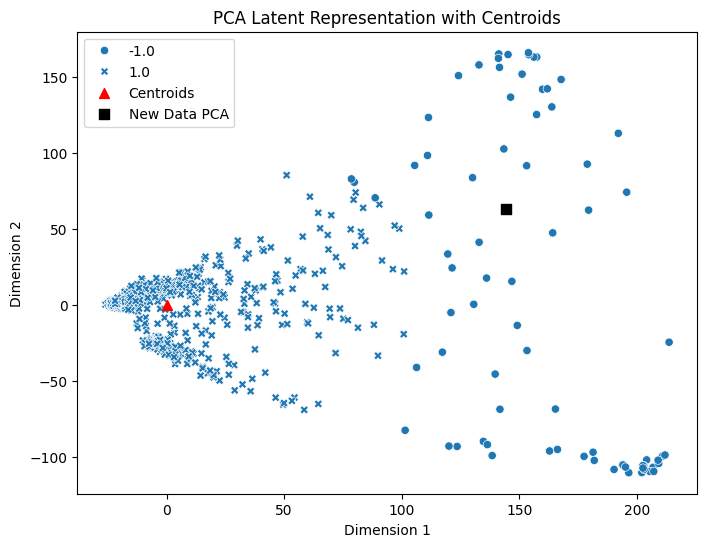

In [ ]:
# Menentukan label untuk scoop dan outscoop
scoop_labels = np.ones(len(X))
scoop_labels[jarak_ke_centroid > outscoop_threshold] = -1

df_pca = plot_vector_distribution(X, kmeans.labels_, scoop_labels, new_embedding)

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Baca data gabungan
df = pd.read_csv(f'{file_path}/{jurnal_id}_data_jurnal.csv')

# Pisahkan fitur dan label
X = df['Data']
y_true = df['Label'] # Label sebenarnya

# Prediksi menggunakan model yang sudah ada (asumsikan fungsi predict_scoop sudah didefinisikan)
y_pred = []
for text in X:
    prediction, _ = predict_scoop(text, tokenizer, model, kmeans, outscoop_threshold, X)
    y_pred.append(1 if prediction == "in scoop" else -1)

# Hitung metrik evaluasi
precision = precision_score(y_true, y_pred, pos_label=1)
recall = recall_score(y_true, y_pred, pos_label=1)
f1 = f1_score(y_true, y_pred, pos_label=1)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.534288     0.37714595]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.537445] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.0484543 -22.790787 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.88266] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.6439886  8.460424 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [8.86394] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.956152  10.986959]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.9875] threshold : 113.10079574584961
inscoop [ True]
new data : [[38.32221    1.4024538]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [38.347862] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.675343    2.1477225]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.776827] threshold : 113.10079574584961
inscoop [ True]
new data : [[-8.890112  8.474077]] cluster center : [[-4.1548

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 12.610669 -13.840492]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.724] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.064125    0.5799057]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.071745] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.318804  -0.763509]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.332472] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.727608   1.144637]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.762556] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.145594   -2.3703213]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.291765] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-17.505398   4.629712]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.10727] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.945467    0.9846946]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.966585] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.44393     3.7362537]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.91934] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.4803305 -23.329075 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.460558] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -4.333272 -26.90036 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.247139] threshold : 113.10079574584961
inscoop [ True]
new data : [[13.2669735  5.297229 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.285419] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.356586    1.2130495]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.39101] threshold : 113.10079574584961
inscoop [ True]
new data : [[178.98218  92.77728]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [201.59921] threshold : 113.10079574584961
inscoop [False]
new data : [[19.518536   -0.91187525]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.539825] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.518814    -0.09190004]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.51901] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.176552    6.7301435]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.795821] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-16.637327    6.2086973]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.758057] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.1700340e+01  1.5954345e-02]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.700346] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 54.4159   -60.729603]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [81.54247] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.0860287e+01  1.0691673e-02]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.860289] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.641619    1.8570571]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.717648] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-1.0764726  6.719713 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [6.8053894] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.4573555 -25.499718 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.733032] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.039894    -0.30652577]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.042128] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.533936     0.93800145]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.554356] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.77999      0.54668236]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.786549] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 6.405469 15.70192 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.958193] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 5.8278747 14.058216 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.218328] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.093449    2.8308237]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.291876] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.483475    2.8429418]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.726841] threshold : 113.10079574584961
inscoop [ True]
new data : [[146.37535 136.82874]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [200.36928] threshold : 113.10079574584961
inscoop [False]
new data : [[  1.8232411 -29.164642 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [29.221577] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -4.5942774 -20.347393 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.859621] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 15.399127 -40.552925]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [43.378254] threshold : 113.10079574584961
inscoop [ True]
new data : [[17.81443   -4.1685553]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.295649] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 0.6946228 11.442237 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.463301] threshold : 113.10079574584961
inscoop [ True]
new data : [[-7.065485 11.095968]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.154527] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.639774  10.394226]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.148859] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-13.610539   6.802772]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.215928] threshold : 113.10079574584961
inscoop [ True]
new data : [[70.06679 59.1969 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [91.72583] threshold : 113.10079574584961
inscoop [ True]
new data : [[  8.954999 -35.44478 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [36.558506] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.820374   -0.1892097]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.821323] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.579369   -0.6304254]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.588167] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-12.410125    6.9044847]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.201518] threshold : 113.10079574584961
inscoop [ True]
new data : [[141.32257 165.24875]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [217.43785] threshold : 113.10079574584961
inscoop [False]
new data : [[  0.19987178 -31.701344  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [31.701973] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.5557692 -22.452105 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.505941] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.245983    0.7427394]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.257845] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.955162     0.68368626]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.964916] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.578873    2.0191486]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.665169] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.875206   1.121237]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.903921] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 64.72729  -19.781729]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [67.68263] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.42794      0.15294063]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.428513] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.885971    1.6719943]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.956137] threshold : 113.10079574584961
inscoop [ True]
new data : [[179.55879   62.517754]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [190.13109] threshold : 113.10079574584961
inscoop [False]
new data : [[ 10.593614 -30.360737]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [32.155857] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.750317    2.6048603]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.913177] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.178373   2.180645]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.290342] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.618151    5.3043017]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.614706] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.175602   -1.1103323]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.204693] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.877434     0.14439568]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.877958] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.634777    1.0291666]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.658163] threshold : 113.10079574584961
inscoop [ True]
new data : [[-4.6417227  8.348143 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.551809] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[46.164646  1.180645]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [46.17974] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.6274633 -25.382887 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.640778] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.146008   2.976995]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.37607] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.33688     5.1958447]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.193106] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.8782      4.2369657]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.401882] threshold : 113.10079574584961
inscoop [ True]
new data : [[181.45    -96.71675]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [205.61671] threshold : 113.10079574584961
inscoop [False]
new data : [[  0.12739724 -29.162458  ]] cluster center : [[-4.1

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-19.91083     3.5301957]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.221361] threshold : 113.10079574584961
inscoop [ True]
new data : [[19.157757  9.386221]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.33356] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.186276 -26.792744]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.290083] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 6.2122955 18.3476   ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.370779] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.306089   6.881865]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.98039] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.80423     2.1220498]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.917595] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.688103    2.7249517]] cluster center : [[-4.1548780e-08  

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-13.4734745   4.792363 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.300393] threshold : 113.10079574584961
inscoop [ True]
new data : [[-25.99782      0.50926274]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.002808] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.757101    2.5182886]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.925396] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.526463    -0.13197935]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.52685] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.2148436e+01  1.7377436e-03]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.148436] threshold : 113.10079574584961
inscoop [ True]
new data : [[105.57172   91.951996]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [140.002] threshold : 113.10079574584961
inscoop [False]
new data : [[-22.996695    2.2920065]] cluster center : [

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-19.626717     0.53402776]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.63398] threshold : 113.10079574584961
inscoop [ True]
new data : [[-7.387308 12.443359]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.470988] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.348455   1.188327]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.384912] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.74247     1.8940125]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.824808] threshold : 113.10079574584961
inscoop [ True]
new data : [[21.811615  7.646019]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.112944] threshold : 113.10079574584961
inscoop [ True]
new data : [[-8.83039    3.5098999]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.5023775] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.301964    0.7510108]] cluster center : [[-4.15

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.086979    0.7788338]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.101357] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.035984    2.1168888]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.14223] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.1052138 -22.994314 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.020859] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.482964    1.6795337]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.548517] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 1.6784561 11.967362 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.084493] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -8.475611 -16.986975]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.984028] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.591812    -0.32683745]] cluster center :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

[[ 26.481964 -45.779167]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [52.886925] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.152958    2.4892392]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.31404] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 8.852049  -5.6740475]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.514447] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.39579      0.13759467]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.396233] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 8.011353 14.81466 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.842087] threshold : 113.10079574584961
inscoop [ True]
new data : [[-8.353636   7.5604916]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.266954] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.475643    2.1508117]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.583076] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.720934   -1.1180146]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.747265] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.738659   9.41216 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.279619] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 53.31854 -62.92247]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [82.47487] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -7.193405 -22.550312]] cluster center : [[-4.154878

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.615526    -0.96789116]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.638235] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.128487     0.86149436]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.14525] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.772182    1.0369021]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.799353] threshold : 113.10079574584961
inscoop [ True]
new data : [[-0.5160041 17.196152 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.203892] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.59296     1.6059834]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.647558] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.457981    1.1906989]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.48818] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.034998    1.1000345]] cluster cente

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.010775    -0.47446552]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.015665] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.12437     2.1969726]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.243937] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.163357    1.9519141]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.249144] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 34.609245 -14.780056]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [37.633095] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.093075    1.7911263]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.162432] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.659903    -0.47330427]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.665073] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.029009    1.9958608]] cluster cen

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[46.54547  -4.016961]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [46.718487] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.103672    -0.54139835]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.110615] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.01213     1.4044334]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.056889] threshold : 113.10079574584961
inscoop [ True]
new data : [[-7.011195 10.944475]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.997629] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.27721     -0.06828788]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.277325] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.76753    -0.5443175]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.774662] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.067816    1.0062242]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.090744] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.208385    1.9178405]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.28749] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.357979    1.2707796]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.39252] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.268986    5.4642816]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.217283] threshold : 113.10079574584961
inscoop [ True]
new data : [[34.947945 34.00681 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [48.762917] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.336018    1.5515158]] cluster center : [[

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-0.88324934 10.99638   ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.031794] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 5.7858257 -6.170264 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [8.458602] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.394052   3.466818]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.779596] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.971596   7.127859]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.581768] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.67976     -0.06611732]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.679852] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.900784   0.616003]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.909859] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.05402     2.0716853]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.160744] threshold : 113.10079574584961
inscoop [ True]
new data : [[  0.6606426 -24.275024 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.284012] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.641235   4.762266]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.272722] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.954056     0.28210294]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.95579] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.660854   2.494415]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.818459] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.70745     0.6361184]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.717218] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.332905   2.757963]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.510445] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.148256    -0.40981033]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.152641] threshold : 113.10079574584961
inscoop [ True]
new data : [[13.81824  11.227305]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.804384] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.849594    0.7414682]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.862171] threshold : 113.10079574584961
inscoop [ True]
new data : [[39.989532 43.312447]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [58.95024] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.484208    4.0847116]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.049157] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.83047     2.6923513]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.995867] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.363953     0.27354717]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.365625]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 threshold : 113.10079574584961
inscoop [ True]
new data : [[ -6.189823 -24.45058 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.22191] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.556871   6.278226]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.038915] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -6.1697063 -23.463295 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.260902] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.71835     1.2699008]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.755444] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.7934     1.509694]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.845627] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.081287   1.806376]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.158537] threshold : 113.10079574584961
inscoop [ True]
new data : [[

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.446148    2.0580273]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.549463] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.8580016 -28.48555  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.546082] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.670013    1.1157439]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.696295] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.397156    2.2881951]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.519157] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.399079   9.035037]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.775803] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.708696    1.7244824]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.780375] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.524298    1.7153332]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.589518] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.475687    1.5918846]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.54414] threshold : 113.10079574584961
inscoop [ True]
new data : [[111.426636 123.47974 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [166.3224] threshold : 113.10079574584961
inscoop [False]
new data : [[-19.379354   2.345116]] cluster center : [[-4

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.750267] threshold : 113.10079574584961
inscoop [ True]
new data : [[-25.182648    1.3190979]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.217173] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.038193    -0.29091004]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.04003] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.073658    -0.08633512]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.073826] threshold : 113.10079574584961
inscoop [ True]
new data : [[34.429707 13.817493]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [37.098892] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.14257     1.2552149]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.17812] threshold : 113.10079574584961
inscoop [ True]
new data : [[  0.1993261 -27.527084 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.527805] threshold : 113.10079574584961
inscoop [ True]
new data : [[  4.060349 -31.817768]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [32.075798] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.51429      0.60616255]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.523243] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.100201   7.811629]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.001106] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.25436      0.19474937]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.255253] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 1.9634197 11.855106 ]] cluster center :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[13.382565 -5.634129]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.520208] threshold : 113.10079574584961
inscoop [ True]
new data : [[59.06496    0.8575473]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [59.071186] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.221516    1.4238769]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.283888] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.85035     1.2191415]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.88285] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.343468    2.0891309]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.436764] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.978134     0.53461206]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.984352] threshold : 113.10079574584961
inscoop [ True]
new data : [[157.43536 125.37941]] cluster center : [[-4.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-7.4812164  9.043821 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.73709] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.17041     1.6071334]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.228584] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.860004    3.2367914]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.109632] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.562283    1.3762375]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.60244] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.719517    4.8313804]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.36637] threshold : 113.10079574584961
inscoop [ True]
new data : [[-3.193143  9.638636]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.1537895] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.850494     0.36695737]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.853724] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.398674    0.8677329]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.415476] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 1.0057635 13.502661 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.540066] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.0089042  8.873562 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.09812] threshold : 113.10079574584961
inscoop [ True]
new data : [[130.18346  83.86932]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [154.86057] threshold : 113.10079574584961
inscoop [False]
new data : [[-15.847072    5.4875436]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.770294] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.100887   2.588122]] cluster center : [[-4.1

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-17.579918    2.5454013]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.763237] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 14.8570385 -31.669815 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [34.98155] threshold : 113.10079574584961
inscoop [ True]
new data : [[20.93301  26.260122]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [33.582508] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.553236    0.1900084]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.553972] threshold : 113.10079574584961
inscoop [ True]
new data : [[-11.4993515  10.341936 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.465792] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.32436    6.142338]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.58575] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.30183      0.79253936]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.316568] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.044632   9.43256 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.757086] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.544304    -0.32460618]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.54664] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.29192     0.9478965]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.31301] threshold : 113.10079574584961
inscoop [ True]
new data : [[101.06203   22.208078]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [103.47334] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.48167     2.4337492]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.61302] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.196967   6.002537]] cluster center : [

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-19.061434    3.4609768]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.37309] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 6.5772166 20.016869 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.06976] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.2039957 -24.12983  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.341616] threshold : 113.10079574584961
inscoop [ True]
new data : [[24.686577  -8.2567425]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.030767] threshold : 113.10079574584961
inscoop [ True]
new data : [[-0.85493934 14.384462  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.409846] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.719788   -1.9506063]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.857758] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.698723  16.92339 ]] cluster center : [[-4

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-0.468178 14.98015 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.987464] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.931004   1.822417]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.003307] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.067726    1.2815299]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.108603] threshold : 113.10079574584961
inscoop [ True]
new data : [[-0.8341143 -8.242264 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [8.284364] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.13723      0.83920443]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.162116] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.598625    5.7831774]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.702388] threshold : 113.10079574584961
inscoop [ True]
new data :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[  3.250241 -29.43536 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [29.614262] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -6.02524  -25.635826]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.334372] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 8.0524981e-03 -3.0399925e+01]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [30.399927] threshold : 113.10079574584961
inscoop [ True]
new data : [[  1.5162218 -25.214062 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.25961] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.067757  -0.116182]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.068048] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.264286    2.2293549]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.38083] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.854832   -0.8214271]] cluster center : [[-4.154

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-4.1548780e-08  7.7384607e-07]]
Distance [21.116957] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.308052     0.10593775]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.308304] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.511112    1.1484412]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.541746] threshold : 113.10079574584961
inscoop [ True]
new data : [[56.98819  23.715977]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [61.726017] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.394709    0.8036629]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.408508] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.421116     0.85954547]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.437586] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -4.715953 -25.584171]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.015188

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[54.91993  19.545696]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [58.294365] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.927578     0.28359947]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.929333] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.838713     0.27089173]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.840393] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.74203     1.4005454]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.78709] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.238735   -0.8062219]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.254032] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.629189    1.7314372]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.69838] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 16.735207 -16.706966]] cluster center : 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  1.2746992 -33.313038 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [33.337418] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.200432   9.397844]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.600365] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.071716    1.8773849]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.147974] threshold : 113.10079574584961
inscoop [ True]
new data : [[10.036688   6.0331154]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.710404] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.130455    0.5959234]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.13813] threshold : 113.10079574584961
inscoop [ True]
new data : [[106.375626 -40.950283]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [113.98552] threshold : 113.10079574584961
inscoop [False]
new data : [[-19.859686    2.5803785]] cluster center : [[-

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.355074    1.7238406]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.424538] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 1.9026797 11.83313  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.985121] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.622185    0.7346213]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.635931] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.867306    0.6769192]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.87778] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.010355     0.32897967]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.01293] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[143.4928  102.78096]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [176.50526] threshold : 113.10079574584961
inscoop [False]
new data : [[-14.301223   4.083637]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.872829] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.473526    3.2522306]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.730225] threshold : 113.10079574584961
inscoop [ True]
new data : [[134.77713  -89.568726]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [161.82532] threshold : 113.10079574584961
inscoop [False]
new data : [[-23.01191      0.19137356]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.012705] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 8.430435 10.890903]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.772581] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -0.34404868 -26.955078  ]] cluster center : [[-4

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -7.212591 -28.214746]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [29.122044] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 1.2703618 12.234526 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.300302] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.39724     0.7474433]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.41029] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.2891445 -23.597736 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.183222] threshold : 113.10079574584961
inscoop [ True]
new data : [[123.61174  -92.903885]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [154.6318] threshold : 113.10079574584961
inscoop [False]
new data : [[-3.1899717  9.945944 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.444984] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.021152   1.792042]] cluster center : [[-4.154

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

[[-10.31665   16.387772]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.364717] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.721045 -24.16227 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.315002] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 32.299423 -52.0961  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [61.296463] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.911833    1.0530815]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.937124] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.882809    1.2457645]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.916695] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.402237    2.4296093]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.546392] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.558678    1.3719883]] cluster center : [[-4.1548780e

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

[[-4.1548780e-08  7.7384607e-07]]
Distance [20.581263] threshold : 113.10079574584961
inscoop [ True]
new data : [[60.99153 71.35825]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [93.87208] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.482597     0.90034187]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.500618] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.1756315  -4.0874677]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.843418] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.040114     0.34819305]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.04615] threshold : 113.10079574584961
inscoop [ True]
new data : [[153.34021  -29.836964]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [156.21608] threshold : 113.10079574584961
inscoop [False]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-19.628906   4.378726]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.111368] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.960337     0.13604638]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.96074] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.22957     1.8888478]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.313433] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 28.753527 -39.378403]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [48.758835] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.394547    0.9030613]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.41453] threshold : 113.10079574584961
inscoop [ True]
new data : [[-1.4420754  4.357437 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [4.5898614] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.340733     0.39749372]] cluster center : 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[ -1.9341778 -28.610943 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.676247] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.385052   -0.3073387]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.38726] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.959076    1.9182149]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.042698] threshold : 113.10079574584961
inscoop [ True]
new data : [[-8.884731 -8.156271]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.060814] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.425632    0.7933054]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.43851] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.815844   1.79064 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.886002] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 5.107752 16.288616]] cluster center : [[-4.1548780e-08  

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.087296    2.8398802]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.269115] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.490578     0.79556954]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.505299] threshold : 113.10079574584961
inscoop [ True]
new data : [[22.39719    4.6876264]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.882483] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.017555    0.8728924]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.035673] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.68938     2.2497003]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.81749] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.875117    4.3151884]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.530647] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.789106     0.37212208]] cluster cent

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

[20.792437] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.30091     3.0239148]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.549053] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.250126   -0.8558774]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.268204] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -6.2315006 -23.360565 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.17742] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.975407    1.4338987]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.022139] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.967655    1.6538005]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.027119] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.25628     1.3684208]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.29831] threshold : 113.10079574584961
inscoop [ T

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 


Distance [21.850489] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.824255   4.864129]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.513288] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.185326    1.6713908]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.254404] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.012548    3.8358972]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.41646] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.120505    4.2395573]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.788455] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 16.709139 -25.807247]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [30.744257] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-15.987349    4.6672287]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.654678] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.758408    1.6520584]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.827354] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.908154    -0.81799084]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.923418] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.237549  -1.496449]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.287842] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.605743  17.506948]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.46888] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.967255     0.21182644]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.968275] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.445152     0.31855878]] cluster cent

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-5.008161  8.860832]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.178212] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.1995616 -27.502945 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.68843] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.677631    0.4973898]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.683916] threshold : 113.10079574584961
inscoop [ True]
new data : [[-11.558956   9.213888]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.781921] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.524853    1.3008885]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.570473] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 2.453702 12.533397]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.771322] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.501467    1.4440756]] cluster center : [[-4.15

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

[22.678131] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.289707    1.3584481]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.333002] threshold : 113.10079574584961
inscoop [ True]
new data : [[-0.36336458 10.1971    ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.20357] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.499011    4.7497864]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.257188] threshold : 113.10079574584961
inscoop [ True]
new data :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-22.218513    3.5929456]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.507145] threshold : 113.10079574584961
inscoop [ True]
new data : [[35.97473   5.494445]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [36.3919] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.22382     0.7684927]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.237103] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.19199      0.88675016]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.208937] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.07454     1.9206634]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.157938] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-19.619343    2.4598417]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.772947] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.202955    5.0537996]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.020947] threshold : 113.10079574584961
inscoop [ True]
new data : [[82.637184 48.258667]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [95.69641] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.2001     7.769327]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.873417] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.65178     -0.02877989]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.651798] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -6.9865294 -26.32264  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.23404] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[157.49359 163.21655]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [226.81242] threshold : 113.10079574584961
inscoop [False]
new data : [[-22.430626     0.48523128]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.435873] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.927288    0.7382865]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.940308] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.363523     0.89677286]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.384277] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -6.54707  -22.026276]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.978706] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.858234    2.8645356]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.045135] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-8.995739   1.1894264]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.074032] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.702772    4.9529767]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.46539] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.96259     1.6492615]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.027369] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.648233   -0.1625416]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.648817] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-9.664442  5.134109]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.943515] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.58633     -0.30847025]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.588348] threshold : 113.10079574584961
inscoop [ True]
new data : [[-1.4413126 12.955902 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.035826] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[33.119694   0.9360118]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [33.132915] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.872467   4.650538]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.501648] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.76773     2.0386348]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.872574] threshold : 113.10079574584961
inscoop [ True]
new data : [[51.08158  85.542145]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [99.633255] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.208008  10.845356]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.329641] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.164936     0.47269082]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.170765] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-2.9883766  8.552166 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.059245] threshold : 113.10079574584961
inscoop [ True]
new data : [[32.790062  4.127374]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [33.0488] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.089139    6.7002425]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.601188] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.386463   1.115947]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.424417] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[75.21452  -8.899173]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [75.73916] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.070585 -23.216267]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.306358] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.663427     0.10412648]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.663666] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.880191 -24.530613]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.225536] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.38446     1.1305497]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.411774] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-2.9625175 13.359228 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.683766] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.646156   8.955584]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.911977] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.053053    4.6477804]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.712341] threshold : 113.10079574584961
inscoop [ True]
new data : [[78.33271  49.913963]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [92.883896] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[156.25165 163.19139]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [225.93364] threshold : 113.10079574584961
inscoop [False]
new data : [[ -4.99814  -23.847239]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.365389] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.478231    2.0036447]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.57602] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.785957   2.295027]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.912273] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 49.14663  -12.961883]]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [50.827175] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.7472      1.2847712]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.78895] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.879646    1.7581732]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.9471] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.885857    1.4962424]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.939383] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.988123    2.1360466]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.091633] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  3.066165 -30.826584]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [30.978697] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 81.42749  -14.807325]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [82.76287] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.683804    5.7216873]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.586409] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.354801    2.4133208]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.504679] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 37.61418  -29.086859]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [47.54863] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 181.95052 -102.09335]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [208.63614] threshold : 113.10079574584961
inscoop [False]
new data : [[-22.002789    1.3205606]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.042381] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.796076    1.5980788]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.857388] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.7756171 -23.218367 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.286163] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-17.51569     4.5104456]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.087109] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.160164   -0.6074169]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.168127] threshold : 113.10079574584961
inscoop [ True]
new data : [[-9.769251 11.399181]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.012648] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.230892    1.5554106]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.287792] threshold : 113.10079574584961
inscoop [ True]
new data : [[-11.671816  -2.19347 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.876136] threshold : 113.10079574584961
inscoop [ True]
new data :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[47.163063 16.134909]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [49.84666] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.850212   5.969136]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.772736] threshold : 113.10079574584961
inscoop [ True]
new data : [[195.75655  74.33527]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [209.39522] threshold : 113.10079574584961
inscoop [False]
new data : [[6.010914  7.1214337]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.319114] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.665045   -1.1392328]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.69978] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 2.8993347 12.449827 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.782969] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.870167     0.53996456]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.877151] threshold : 113.10079574584961
inscoop [ True]
new data : [[16.078417 14.992355]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.98377] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.909489    2.6740675]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.079786] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.714912    0.7364136]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.727999] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.14594     1.1671846]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.176678] threshold : 113.10079574584961
inscoop [ True]
new data : [[-3.7270963 11.101387 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.710339] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[20.40945  12.298876]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.828722] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 35.763275 -56.585785]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [66.939995] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.10726     3.6029143]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.386457] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.14095     1.2091174]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.172516] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.2725365 -26.177095 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.38086] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.769947    1.0393698]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.794744] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -4.82242  -25.952648]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.396887] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.91836     1.0656211]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.943121] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.414959    2.6752362]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.589499] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.37595     0.9300655]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.394445] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -9.126282 -24.788647]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.41526] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.311892    1.7984401]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.387638] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.77032    1.045844]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.795427] threshold : 113.10079574584961
inscoop [ True]
new data : [[  0.42530012 -28.775175  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.778318] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.63872     0.8378396]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.654217] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.419888   4.216485]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.922924] threshold : 113.10079574584961
inscoop [ True]
new data :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-23.168129     0.51116663]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.173767] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.968204     0.51609206]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.974266] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.709406   -2.3810868]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.860313] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-15.622725   5.849371]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.681866] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.852154    1.0441716]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.879595] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.84318     0.6645004]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.853285] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-19.955936    1.2704397]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.996336] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.451015    2.6428883]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.629745] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -4.5913744 -23.34391  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.791153] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.507786   5.481924]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.851795] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.917935   5.670179]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.89768] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 193.98685 -104.85054]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [220.50972] threshold : 113.10079574584961
inscoop [False]
new data : [[22.627542  8.49806 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.170698] threshold : 113.10079574584961
inscoop [ True]
new data : [[  1.8741918 -27.778942 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.842094] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.7079086 -2.346274 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [3.582984] threshold : 113.10079574584961
inscoop [ True]
new data : [[-11.849022   9.466896]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.166457] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 206.96419  -106.666016]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [232.8343] threshold : 113.10079574584961
inscoop [False]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.207638    1.6692955]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.273233] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.094677    2.1149664]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.200436] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.36615     6.7254333]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.62296] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.151695    1.4750416]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.20075] threshold : 113.10079574584961
inscoop [ True]
new data : [[-5.0674295 11.941777 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.9724655] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[19.010307   4.7144194]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.586157] threshold : 113.10079574584961
inscoop [ True]
new data : [[165.43521 -68.31743]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [178.98625] threshold : 113.10079574584961
inscoop [False]
new data : [[-20.666012     0.33415735]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.668713] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.453453    2.0415504]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.56604] threshold : 113.10079574584961
inscoop [ True]
new data : [[26.285107 21.239449]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [33.7938] threshold : 113.10079574584961
inscoop [ True]
new data : [[  5.845205 -31.210583]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [31.75322] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.44274     1.0275985]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.46525] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.673439   2.60222 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.836569] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 2.1960196 11.311685 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.522877] threshold : 113.10079574584961
inscoop [ True]
new data : [[  6.0255704 -31.942902 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [32.506252] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.247673    1.5263956]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.299974] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.524748     0.87053245]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.541563] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.98582      0.42721206]] cluster center

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-13.809226   2.618712]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.055332] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.465824   2.213718]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.585201] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.850151    2.8818908]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.127203] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.9148493 -24.240381 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.315893] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.367756    2.4485369]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.514404] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.395346   3.004257]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.668322] threshold : 113.10079574584961
inscoop [ True]
new data : [[151.251   151.96933]] cluster center : [[-4.1

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-14.5637245   2.0912936]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.713109] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 205.59698  -109.380905]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [232.8826] threshold : 113.10079574584961
inscoop [False]
new data : [[-21.853033    2.4157457]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.986153] threshold : 113.10079574584961
inscoop [ True]
new data : [[-8.273603  -2.3701732]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [8.606407] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.54253     2.6870716]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.717525] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.079527   -1.1466494]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.110691] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.651089    0.5704225]] cluster center : [[-4.15487

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.128843     0.93780065]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.150677] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.967873    3.7953255]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.364338] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.329101    9.6505165]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.656921] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.367485    2.6018357]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.52531] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.821018    1.3285925]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.85966] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.621292   4.939407]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.433079] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.359165    -0.34312844]] cluster cente

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 5.2530146 12.056371 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.151053] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.660576    2.7135458]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.83801] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.491854    5.6483874]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.489445] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 8.168762  13.9825325]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.193823] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.550585     0.04523589]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.550634] threshold : 113.10079574584961
inscoop [ True]
new data : [[2.4135275 7.289448 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [7.6786165] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.624227   5.753084]] cluster center : [[-4.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 8.432373 15.615646]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.746923] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.716549    0.5198679]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.722496] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.549126    -0.14351979]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.549562] threshold : 113.10079574584961
inscoop [ True]
new data : [[19.510664  -1.5762358]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.574232] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.150576    1.9616022]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.241344] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.221774  10.564112]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.923822] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.786915    1.2358094]] cluster center : [[

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 2.2140245 10.051737 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.292682] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.646996    2.0595603]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.749464] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.734995     0.06593639]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.7351] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.2022705   2.3527606]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.427022] threshold : 113.10079574584961
inscoop [ True]
new data : [[132.96451  41.39061]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [139.25783] threshold : 113.10079574584961
inscoop [False]
new data : [[-23.740694     0.22120342]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.741724] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.702177    0.8569629]] cluster center : 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 14.976334 -18.645723]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.91555] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.076622     0.78354204]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.09052] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.998207    2.5008423]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.139904] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.96067     1.2918534]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.000443] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.302078    -0.29633597]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.304047] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.846413     0.70881677]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.857407] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 8.50273  12.348831]] cluster center 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[164.28549   47.584633]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [171.03807] threshold : 113.10079574584961
inscoop [False]
new data : [[-21.369928    -0.41431805]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.373943] threshold : 113.10079574584961
inscoop [ True]
new data : [[37.487144 11.201287]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [39.124863] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.393501   4.301921]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.889875] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.748543   7.990656]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.659761] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 17.876308 -34.946815]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [39.253563] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 2.6182504 15.566954 ]] cluster center : [[-4.154

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[20.711182  8.72139 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.472553] threshold : 113.10079574584961
inscoop [ True]
new data : [[  8.809238 -38.635822]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [39.627384] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.440125    1.6551503]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.501081] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.784782   2.19204 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.894789] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.920525    0.6553358]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.929892] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.8056982 -12.168343 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.749585] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.9449      2.5870907]] cluster center : [[-4

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[79.86041 80.84703]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [113.639465] threshold : 113.10079574584961
inscoop [False]
new data : [[-15.788537   5.541871]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.732908] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.5877      3.4846601]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.867136] threshold : 113.10079574584961
inscoop [ True]
new data : [[32.653923 -4.646821]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [32.9829] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.20985     1.9358066]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.298006] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 209.39807 -104.11163]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [233.85205] threshold : 113.10079574584961
inscoop [False]
new data : [[-22.814655     0.65146303]] cluster center : [[-4.1548

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-20.248       1.8563056]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.332912] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.996494     0.82789695]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.014526] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.850685    1.8006873]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.936493] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.672197    2.5694542]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.823982] threshold : 113.10079574584961
inscoop [ True]
new data : [[  0.6812588 -28.797329 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.805386] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.664957    7.3776555]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.416174] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.7089    -1.548674]] cluster center : [[-4.1

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.386986   1.754644]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.458843] threshold : 113.10079574584961
inscoop [ True]
new data : [[  1.925317 -27.310913]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.378693] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.604053    -0.08496034]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.604221] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 10.237555 -35.27528 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [36.730816] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.138313    0.3057264]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.140524] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.9132      0.2611072]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.914688] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.295528    1.2033257]] cluster center : 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 19.500828 -10.55957 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.176268] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.445276   1.256953]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.483877] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.021038   0.921289]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.040302] threshold : 113.10079574584961
inscoop [ True]
new data : [[-9.990843 13.520105]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.811014] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.56261     5.1208467]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.256] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.073536     0.23568468]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.074795] threshold : 113.10079574584961
inscoop [ True]
new data : [[141.18683 162.36256]] cluster center : [[-4.154878

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 3.4692473 13.293673 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.7389] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.087326     0.95493424]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.107067] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.047363     0.48985642]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.052351] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.800985    3.4716744]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.15592] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 15.343169 -41.49514 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [44.240925] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.538685    1.1877519]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.573] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.868034   2.364523]] cluster center : [[-4

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.662899    2.7791872]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.840446] threshold : 113.10079574584961
inscoop [ True]
new data : [[68.56298  46.189453]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [82.67011] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.675824   6.401313]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.200468] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.07793    2.329504]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.212616] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.822056     0.64022624]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.831036] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 36.475056 -48.39315 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [60.599724] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.323338    0.2776213]] cluster center : [[-4.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  3.4164019 -17.959446 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.281507] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.32093     -0.07820201]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.32106] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.61723      0.34741348]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.620655] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.159578    1.8864938]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.247654] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.4502506 -27.5587   ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.667412] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.390682     0.40123358]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.394445] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.151543    0.9895917]] cluster 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-1.340925  9.270197]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.366675] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 6.240594 16.177048]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.339027] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.030188    1.0425406]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.052792] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.404694     0.03792128]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.404724] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.1870901e+01 -4.5013428e-03]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.870901] threshold : 113.10079574584961
inscoop [ True]
new data : [[-0.2033951 17.23244  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.233643] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.0116344e+01 -9.2184842e-03]] cluster ce

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[44.37436 38.0167 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [58.43247] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.033554    -0.03131846]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.033577] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.031948    3.6232123]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.341755] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.673098    3.4829047]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.080796] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.032993   2.473914]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.171446] threshold : 113.10079574584961
inscoop [ True]
new data : [[149.20673  -13.301274]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [149.79843] threshold : 113.10079574584961
inscoop [False]
new data : [[-21.840015    0.7984557]] cluster center : [[-4.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.522417   -1.0118302]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.546188] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.762253     0.95021415]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.782988] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.54451  -26.680557]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.250572] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.263533    2.1962492]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.382204] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.0602      1.0534413]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.08425] threshold : 113.10079574584961
inscoop [ True]
new data : [[  3.293939 -13.569744]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.963811] threshold : 113.10079574584961
inscoop [ True]
new data : [[40.857327 11.67572 ]] cluster center : [[-

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-5.2193103  7.8729687]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.445889] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.500626    1.0216258]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.522821] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.861233  10.342602]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.105955] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.3472217 -25.294052 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.329905] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.6084      2.6605678]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.808268] threshold : 113.10079574584961
inscoop [ True]
new data : [[-1.4960895 14.818243 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.893575] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.282265    -0.84415615]] cluster center : [

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[12.308238  3.836466]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.892292] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.040543    0.7644192]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.053795] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.329733    2.9619365]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.544369] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.55652      0.02952614]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.55654] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.228622    1.8726819]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.311062] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.725697    0.5783099]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.733053] threshold : 113.10079574584961
inscoop [ True]
new data : [[26.371632 15.227396]] cluster center : [[-

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-14.181995   -0.6362454]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.19626] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.49702  -23.848917]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.474232] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.234371    1.2725544]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.270758] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.680836    1.3220716]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.721107] threshold : 113.10079574584961
inscoop [ True]
new data : [[17.698282 15.528962]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.545229] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 25.822222 -12.880123]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.856276] threshold : 113.10079574584961
inscoop [ True]
new data : [[130.70444    0.575118]] cluster center : [[-4.15

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-12.736826    5.9623117]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.063281] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.416368    -0.88438827]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.43462] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.005857   0.971416]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.027287] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.94534     4.9761314]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.660872] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 4.364058 14.095757]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.755857] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.979372   1.41573 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.02492] threshold : 113.10079574584961
inscoop [ True]
new data : [[-7.0109873  2.100366 ]] cluster center : [[-4.1

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-17.428593    1.0726488]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.461569] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.0485084 -22.54031  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.564684] threshold : 113.10079574584961
inscoop [ True]
new data : [[166.31046 -94.86852]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [191.46593] threshold : 113.10079574584961
inscoop [False]
new data : [[-20.702164   1.800777]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.780336] threshold : 113.10079574584961
inscoop [ True]
new data : [[  8.958863 -23.098726]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.775238] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.422129   6.895046]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.985601] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.818708    2.2589486]] cluster center : [[-4.1

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-4.9940634  6.503166 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [8.199502] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.11333     5.0241947]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.8356] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.959219    1.2819071]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.994978] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.785141 -23.845848]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.537569] threshold : 113.10079574584961
inscoop [ True]
new data : [[98.97693 50.40535]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [111.07264] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.396713    4.6902456]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.054342] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.884247    1.7046154]] cluster center : [[-4.1548

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 204.24213 -101.78166]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [228.19806] threshold : 113.10079574584961
inscoop [False]
new data : [[-22.438       2.5418386]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.581514] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.604112    5.2520113]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.519784] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.112561   4.360776]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.72914] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.927307    2.6692185]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.089172] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 17.611685 -44.800232]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [48.137638] threshold : 113.10079574584961
inscoop [ True]
new data : [[145.27649 164.83694]] cluster center : [[-4.15

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-16.121761    5.7325773]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.110628] threshold : 113.10079574584961
inscoop [ True]
new data : [[167.85988 148.46414]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [224.09494] threshold : 113.10079574584961
inscoop [False]
new data : [[  1.6930768 -31.90967  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [31.954556] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.21772     3.2994657]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.498903] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.710014   1.708104]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.780334] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.507536   5.842931]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.022818] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.476519    0.8589837]] cluster center : [[-4

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.228603   3.090171]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.452337] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.836159   5.518248]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.717428] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.633474    2.3821614]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.764235] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.273914    0.5695415]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.280884] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.173601    -0.21959634]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.174858] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.215084    0.4643256]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.220165] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.333682    5.3301487]] cluster center 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 88.22023  -12.893452]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [89.15745] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.409086    2.2656164]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.555891] threshold : 113.10079574584961
inscoop [ True]
new data : [[-3.7354238  2.5084064]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [4.499499] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.480425    1.8687435]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.56156] threshold : 113.10079574584961
inscoop [ True]
new data : [[97.04935  52.326332]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [110.257065] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.4159355   1.1271099]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.457084] threshold : 113.10079574584961
inscoop [ True]
new data : [[18.739435  -1.9777288]] cluster center : [[-4.154

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

inscoop [ True]
new data : [[ -5.6789103 -24.363094 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.016203] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.999989   -1.0223576]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.0227] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 59.81987  -11.224453]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [60.863823] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 11.466037 -31.863455]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [33.863693] threshold : 113.10079574584961
inscoop [ True]
new data : [[10.61833  16.534124]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.650093] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.3085074 -26.016811 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.552866] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -4.413171 -22.269382]] cluster c

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.806309    2.1271324]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.91476] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.840885    -0.18042356]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.841599] threshold : 113.10079574584961
inscoop [ True]
new data : [[138.53102 -98.9297 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [170.22905] threshold : 113.10079574584961
inscoop [False]
new data : [[ -3.173411 -22.945953]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.164354] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.257961    -0.10157022]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.258204] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.804363    0.6263774]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.812963] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.7696264 -30.681591 ]] cluster center :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-2.9754672  9.610767 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.060826] threshold : 113.10079574584961
inscoop [ True]
new data : [[90.53526  66.308395]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [112.22049] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.319475   0.781536]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.332567] threshold : 113.10079574584961
inscoop [ True]
new data : [[40.79654 36.78016]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [54.92848] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.382172    -0.16125625]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.38292] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 1.3590825 10.448639 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.536657] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.237034    2.2211175]] cluster center : [[-4.1548780

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.329678    1.4989444]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.377783] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 2.7118554 10.477567 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.8228245] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.267962    1.5586748]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.322447] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.93359     2.1651583]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.040197] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.3489857e+01 -1.9197792e-02]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.489864] threshold : 113.10079574584961
inscoop [ True]
new data : [[211.1124   -99.186035]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [233.2516] threshold : 113.10079574584961
inscoop [False]
new data : [[ -3.0566883 -24.097004 ]] cluster cen

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[41.157433 12.102827]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [42.900032] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.314102    2.8396995]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.511621] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.324848    2.0001986]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.41845] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.020685    6.7700562]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.31768] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.870266   8.737561]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.9466] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 6.7089834 11.861936 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.627764] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.98998     1.8977885]] cluster center : [[-4.154

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [ True]
new data : [[-23.624132     0.04528385]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.624176] threshold : 113.10079574584961
inscoop [ True]
new data : [[-5.2547474  6.3489842]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [8.241478] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.80893    1.155719]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.857208] threshold : 113.10079574584961
inscoop [ True]
new data : [[-5.782321  9.326239]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.973329] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.73491     2.3484557]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.86748] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.312557    1.0213466]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.33492] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.993782    1.1852795]] cluster cente

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  0.23772591 -28.63322   ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.634207] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.456837   0.820361]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.477272] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.928577     0.76922655]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.941477] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.778477    1.7570337]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.84924] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.899567   5.586073]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.798864] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.986683    1.0001479]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.011692] threshold : 113.10079574584961
inscoop [ True]
new data : [[141.64305 156.43327]] cluster center : [

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 


inscoop [ True]
new data : [[-23.55537      0.34454095]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.55789] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 20.013   -47.44658]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [51.494644] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.448466   9.705805]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.260893] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.89589     1.5070722]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.950167] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.329924    3.0854557]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.562729] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.7574      1.8830806]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.846937] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.31718      0.18110497]]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

113.10079574584961
inscoop [ True]
new data : [[-23.865395    -0.25777203]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.866787] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.620766    1.2705011]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.658062] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.538492    3.7054763]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.003276] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -4.2594233 -22.550339 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.949083] threshold : 113.10079574584961
inscoop [ True]
new data : [[-6.576745 10.614057]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.486463] threshold : 113.10079574584961
inscoop [ True]
new data : [[  2.892621 -33.71537 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [33.83923] threshold : 113.10079574584961
inscoop [ True]
new data : [[-1.202198

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-16.981499   8.842318]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.1457] threshold : 113.10079574584961
inscoop [ True]
new data : [[  3.6363754 -38.704292 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [38.87474] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 202.1973  -110.14111]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [230.24945] threshold : 113.10079574584961
inscoop [False]
new data : [[-17.45353    3.402893]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.782166] threshold : 113.10079574584961
inscoop [ True]
new data : [[  3.7852092 -34.36466  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [34.572495] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.0006824 -23.621714 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.145231] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.426197    1.5542843]] cluster center : [[-4.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.92309     1.5779833]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.977339] threshold : 113.10079574584961
inscoop [ True]
new data : [[-0.57608   -2.9274492]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [2.9835937] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.015451    1.1038347]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.043106] threshold : 113.10079574584961
inscoop [ True]
new data : [[77.16406  -9.801119]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [77.78403] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.1207920e+01  6.1142445e-03]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.20792] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 196.64905 -110.20669]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [225.42484] threshold : 113.10079574584961
inscoop [False]
new data : [[-18.544472    3.5504966]] cluster center : 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-15.275591    6.2612567]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.508997] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.828442    0.9353357]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.84847] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.033684    5.6455975]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.944893] threshold : 113.10079574584961
inscoop [ True]
new data : [[96.29578  23.696842]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [99.16863] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -0.7291812 -28.624142 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.633427] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.899187   4.595824]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.51297] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.20414     1.1411788]] cluster center : [[-4.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -6.9613824 -25.596394 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.526142] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.4664593 -24.595358 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.195513] threshold : 113.10079574584961
inscoop [ True]
new data : [[  1.1036878 -27.5752   ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.597279] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.861832     0.83192587]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.878414] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 8.444149  -2.2195113]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [8.730972] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.540771    -0.09126964]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.540956] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 194.18208  -105.135086]] cluster cent

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.513533     0.95750463]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.53483] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.27644     1.3714528]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.318617] threshold : 113.10079574584961
inscoop [ True]
new data : [[13.655284 20.803524]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.884804] threshold : 113.10079574584961
inscoop [ True]
new data : 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

[[101.500626 -82.28215 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [130.66266] threshold : 113.10079574584961
inscoop [False]
new data : [[22.86652   -6.1789265]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.68664] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.6136923 -23.291708 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.958656] threshold : 113.10079574584961
inscoop [ True]
new data : [[30.32351 42.42566]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [52.14836] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[88.75168 70.61713]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [113.417984] threshold : 113.10079574584961
inscoop [False]
new data : [[-22.402187     0.26628074]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.40377] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.889752   9.01228 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.727902] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.39732     1.4058307]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.441397] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  1.7953969 -19.160524 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.244457] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.035175    1.2430942]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.073704] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.340557    1.6665598]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.40553] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.303936    1.5822332]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.362612] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.563343    3.2647123]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.820889] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-13.18531     5.9397964]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.461452] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.861286     0.99172807]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.88377] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-14.449705   2.454774]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.656735] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.192446     0.54297197]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.1994] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.154957    3.1247225]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.395739] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 49.953003 -64.395874]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [81.49927] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.328837    6.4408956]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.80348] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.496582   1.299625]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.532495] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.893242    1.0207361]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.915987] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -3.0931072 -21.757158 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.975924] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.034626    1.2202759]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.071754] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.340893    1.6560223]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.402185] threshold : 113.10079574584961
inscoop [ True]
new data : [[-1.9044958 10.980669 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.144603] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.698235     0.79101336]] 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.712013] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.149874    5.2911506]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.905401] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -9.388071 -26.95708 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.545053] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.996479    1.4956748]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.04727] threshold : 113.10079574584961
inscoop [ True]
new data : [[2.1789873 6.4847884]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [6.841086] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.394052   3.466818]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.779596] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-11.527943    7.7769575]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.905916] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.879517   2.357572]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.000662] threshold : 113.10079574584961
inscoop [ True]
new data : [[-4.530463  8.528986]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.657571] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.722774 -12.034591]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.512863] threshold : 113.10079574584961
inscoop [ True]
new data : [[80.45631 74.10077]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [109.380714] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-12.74819     4.6072936]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.555202] threshold : 113.10079574584961
inscoop [ True]
new data : [[-8.992104  6.764518]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.252404] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.40627     5.6416607]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.406752] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.10539      0.38017803]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.108519] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.727749   2.242118]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.843126] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 0.5768341 15.718933 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.729512] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.250185    3.4731154]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.532137] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.474548    1.9463649]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.558672] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 195.25356 -106.48996]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [222.40518] threshold : 113.10079574584961
inscoop [False]
new data : [[82.89006  45.526497]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [94.56968] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-17.07945     4.3148026]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.616049] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.18896    -0.7946991]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.203857] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.456444    -0.27768567]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.458328] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-2.4103806 13.670603 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.881474] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.586567    4.4244733]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.105927] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.7878222 -24.719017 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.783585] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.947376    1.5045522]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.998886] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -4.2856817 -26.071083 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.420984] threshold :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 113.10079574584961
inscoop [ True]
new data : [[22.855108 29.965254]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [37.6865] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.634953     0.38100332]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.638308] threshold : 113.10079574584961
inscoop [ True]
new data : [[50.232227 -5.556728]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [50.538635] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.453773   -0.5858462]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.461414] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.6795      1.8926661]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.755018] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.537994    2.8870156]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.750141] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.4385679 -25.848694 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.0764] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.027584    1.4264232]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.069887] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.530804    1.1863295]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.56069] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.275904 -15.041567]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.415113] threshold : 113.10079574584961
inscoop [ True]
new data : [[-3.3367105 10.805141 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.308612] threshold : 113.10079574584961
inscoop [ True]
new data : [[  5.3000984 -27.905895 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.404755] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.56301     1.0577484]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.588938] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 203.04057 -105.6364 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [228.87665] threshold : 113.10079574584961
inscoop [False]
new data : [[-18.802464   -0.9200988]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.824963] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.686333    1.0298831]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.709698] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.800068   5.950173]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.768244] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.97485     2.0760283]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.08808] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[33.722847 30.722092]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [45.618828] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.12408     1.6542715]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.188755] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.515991    4.1030083]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.125038] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.56108      0.21577275]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.56216] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.968195   4.42453 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.569843] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.230255    2.0499449]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.320528] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.494999    0.8028178]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.50932] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.422668   -0.3982372]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.426205] threshold : 113.10079574584961
inscoop [ True]
new data : [[  8.024883 -29.514524]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [30.58604] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 203.18048 -107.97891]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [230.09074] threshold : 113.10079574584961
inscoop [False]
new data : [[-21.486492     0.98904073]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.509243] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.47507     1.0855057]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.50127] threshold : 113.10079574584961
inscoop [ True]
new data : [[74.68154  25.639864]] cluster center : [[-4.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-6.711771   6.5428214]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.373173] threshold : 113.10079574584961
inscoop [ True]
new data : [[14.480597 24.961323]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.8575] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 0.4013133 13.132437 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.138567] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.817669   8.117238]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.67414] threshold :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 113.10079574584961
inscoop [ True]
new data : [[ 28.99647  -56.015907]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [63.075962] threshold : 113.10079574584961
inscoop [ True]
new data : [[  4.2783337 -29.21986  ]]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [29.531414] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.088923     0.28740233]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.09071] threshold : 113.10079574584961
inscoop [ True]
new data : [[66.495384 22.62733 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [70.23982] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -3.55932  -20.598406]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.903662] threshold : 113.10079574584961
inscoop [ True]
new data : [[-1.1864696 15.34613  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.391927] threshold : 113.10079574584961
inscoop [ True]
new data : [[154.10059 164.802  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [225.6251] threshold : 113.10079574584961
inscoop [False]
new data : [[-2.3654152e+01 -2.2104383e-03]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.654152] threshold : 113.10079574584961
inscoop [ True]
new data : [[65.31825 50.55726]]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [82.59849] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.91083     3.5301957]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.221361] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.978696 -28.28754 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.443937] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[136.13936  17.83131]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [137.30215] threshold : 113.10079574584961
inscoop [False]
new data : [[  3.5027924 -27.478899 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.701254] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.053045    0.6468961]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.062983] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[146.9092    15.684185]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [147.74406] threshold : 113.10079574584961
inscoop [False]
new data : [[-21.251705    -0.40038466]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.255476] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.491615    1.4564868]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.543312] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.229969    0.9867459]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.251858] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -3.0233784 -27.689617 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.854187] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.502548   -1.0375069]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.526453] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 19.211143 -19.884254]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.648718] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.06644      0.11180383]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.066738] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.256918  -0.941201]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.275955] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.4981      3.1903753]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.733541] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.013523    1.9636123]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.100927] threshold : 113.10079574584961
inscoop [ True]
new data : [[  1.4787757 -27.197573 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.237743] threshold : 113.10079574584961
inscoop [ True]
new data : [[72.07533  31.558575]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [78.68162] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 202.63782 -105.50728]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [228.45978] threshold : 113.10079574584961
inscoop [False]
new data : [[-2.0887812e+01  1.7939895e-02]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.88782] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[80.19287  38.906166]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [89.13241] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -4.697028 -23.782232]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.24163] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.762646     0.95988804]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.785944] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 25.434177 -34.001823]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [42.462] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[62.67873 -1.66244]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [62.70077] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.5502381 -26.699894 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.934895] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.173466    1.8419604]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.253435] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.040226    2.1700048]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.146795] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.032661    2.3609753]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.164759] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.588453    -0.20520663]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.589386] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.056663 -24.958439]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.144917] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.280584     0.06638372]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.280687] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.409388    1.7881336]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.477583] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  0.39775318 -22.823656  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.827122] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.743416    1.5771115]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.800537] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.312275    2.2268505]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.423124] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.539167    1.9156516]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.624186] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.072926    0.7035134]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.084665] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.552507   1.920556]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.646605] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.972937    0.9467561]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.991625] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -8.707021 -13.736021]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.263165] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.071415    1.2683016]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.107826] threshold : 113.10079574584961
inscoop [ True]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 


new data : [[16.612099 31.936508]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [35.998642] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 10.976526 -31.152225]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [33.02946] threshold : 113.10079574584961
inscoop [ True]
new data : [[  2.0578227 -27.914185 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.989933] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.55096    6.019616]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.919854] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -9.220425 -11.857777]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.020756] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -0.5565748 -27.149385 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.155088] threshold : 113.10079574584961
inscoop [ True]
new data : [[  4.8640776 -36.500656 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [36.823322] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.345634   3.13654 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.61183] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.878242    -0.39541247]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.88166] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.912678     0.28699598]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.914646] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.804787    1.5991632]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.866156] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.510079   6.552356]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.122161] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.489143  -1.496264]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.549587] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-14.140384   4.599082]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.869499] threshold : 113.10079574584961
inscoop [ True]
new data : [[-1.2547681 13.809223 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.866113] threshold : 113.10079574584961
inscoop [ True]
new data : [[24.161057  7.048744]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.168262] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.862408    5.1547284]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.730937] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[1.7449474 9.192003 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.356161] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.16224     2.2206886]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.284164] threshold : 113.10079574584961
inscoop [ True]
new data : [[-4.798972  5.414628]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [7.2352138] threshold : 113.10079574584961
inscoop [ True]
new data : [[58.053204 22.8149  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [62.37543] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-2.2123487  9.84539  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.090896] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 1.4467937 11.990866 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.077833] threshold : 113.10079574584961
inscoop [ True]
new data : [[-6.826234 14.479023]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.007484] threshold : 113.10079574584961
inscoop [ True]
new data : [[-1.0182841 10.29415  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.344391] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.6490178 -21.968616 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.269608] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 6.5866528 21.903316 ]]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.872238] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.578595    3.7662015]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.02738] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.974962    1.3341496]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.019468] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.09114     0.9501624]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.112532] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.450619    3.7041821]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.783377] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -7.4169817 -24.33316  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.438442] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[67.50488  11.981889]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [68.560005] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.634254   -0.3761947]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.637524] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.428585   -1.4293288]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.474083] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 9.309149 19.22966 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.364458] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 0.37571922 11.7007065 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.706736] threshold : 113.10079574584961
inscoop [ True]
new data : [[69.394806  -2.2925775]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [69.43266] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.152748   2.816672]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.39649] threshold : 113.10079574584961
inscoop [ True]
new data : [[-0.8251798  7.771709 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [7.815393] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.667812    0.5314396]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.67404] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.96896     1.1066426]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.99814] threshold : 113.10079574584961
inscoop [ True]
new data : [[-11.065518    1.1952585]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.129885] threshold : 113.10079574584961
inscoop [ True]
new data : [[  1.9600966 -28.92772  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.99405] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 2.7167988 13.418688 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.690951] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.463707    2.0580945]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.56694] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -6.268475 -24.315914]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.110903] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.289562    4.7412605]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.863705] threshold : 113.10079574584961
inscoop [ True]
new data : [[91.66407  29.390518]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [96.260605] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.34504      0.73585236]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.357153] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[153.95474 166.06058]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [226.44685] threshold : 113.10079574584961
inscoop [False]
new data : [[-20.297836   1.322243]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.340858] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.352327    -0.56798506]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.359234] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.423971    1.3569659]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.469] threshold : 113.10079574584961
inscoop [ True]
new data : [[0.6949502 7.9901843]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [8.020348] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.213139    5.8737297]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.136852] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.420845     0.93407786]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.442198] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.678356    1.2861857]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.716478] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-1.9291006  9.13802  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.339422] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.297785    7.1738224]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.89633] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 64.550095 -64.96245 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [91.57966] threshold : 113.10079574584961
inscoop [ True]
new data : [[-11.483004  -9.065297]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.630072] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-18.34317     2.6400244]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.532179] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.526634     0.08673665]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.526802] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.926029   7.429386]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.7838545] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.110477    1.5009035]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.157148] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.169456    1.6227455]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.23463] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.282167   9.416796]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.1072] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.99976    2.117898]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.097065] threshold : 113.10079574584961
inscoop [ True]
new data : [[  1.4302685 -27.260666 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.29816] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.549654   1.99894 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.63808] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-15.957916   4.363041]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.543615] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.620094    -0.11372298]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.620358] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.550398    -0.38853112]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.553745] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.992435   1.9668  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.080206] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[68.88031 36.62031]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [78.0099] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.505413    2.4706724]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.64687] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.085226    1.5366619]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.141148] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.478308    -0.09086367]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.47849] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[139.79843 -45.32023]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [146.96097] threshold : 113.10079574584961
inscoop [False]
new data : [[-14.735655   6.107795]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.951322] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 202.6962  -107.15074]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [229.27501] threshold : 113.10079574584961
inscoop [False]
new data : [[-21.804562    1.4403214]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.852081] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.840418    1.2202829]] cluster center : [[-4.1548780e-08  7.7384607e-07]]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 


Distance [21.874481] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.6311026 -25.9869   ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.590002] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.532446   1.300887]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.568375] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.223839    6.6040983]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.171318] threshold : 113.10079574584961
inscoop [ True]
new data : [[53.615273 10.770991]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [54.686485] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.938671     0.81175995]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.953684] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.427883   3.022685]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.66162] threshold : 113.10079574584961
inscoo

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[212.0326  -98.55136]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [233.81657] threshold : 113.10079574584961
inscoop [False]
new data : [[-21.281513   -2.0128279]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.37649] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.742851    1.2094474]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.77808] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.342327   8.665031]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.497417] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[51.61267  29.367975]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [59.38304] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.7992538 -27.159452 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.218985] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.617216   5.092266]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.538217] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.608257    -0.05231416]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.60832] threshold : 113.10079574584961
inscoop [ True]
new data : [[33.192577  9.712553]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [34.5844] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.409166    1.4810132]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.460331] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-17.448683    3.1509905]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.730913] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 21.330662 -43.483036]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [48.433167] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.200733   6.251478]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.192799] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.90006    4.098423]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.339321] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -0.72924405 -32.472313  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [32.4805] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.975306    1.1634077]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.007545] threshold : 113.10079574584961
inscoop [ True]
new data : [[3.564376 9.479913]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.127858] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.828354    0.9326038]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.850273] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.927906    6.9374466]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.22337] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 2.8434045 -6.1216035]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [6.74974] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.656067    -0.31706175]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.6585] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.359741    1.5876813]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.416039] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.423512    2.3113708]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.553886] threshold : 113.10079574584961
inscoop [ True]
new data :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-21.419495   -0.2711446]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.421211] threshold : 113.10079574584961
inscoop [ True]
new data : [[  5.8632846 -27.77642  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.388514] threshold : 113.10079574584961
inscoop [ True]
new data : [[79.565445 69.35863 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [105.55226] threshold : 113.10079574584961
inscoop [ True]
new data : [[14.930637 10.41223 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.202703] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.473411   3.79464 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.962584] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.920486    2.6927485]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.093071] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.80967     1.3874679]] cluster center : [[-4.1548780e-08

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 60.200573 -11.963495]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [61.3778] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.126488    2.5239997]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.301369] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.723264 -26.847569]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.98533] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.202555   -0.1953036]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.203499] threshold : 113.10079574584961
inscoop [ True]
new data : [[  4.7840095 -29.799751 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [30.181316] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.878471    3.0634623]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.091906] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 190.37994 -108.04538]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [218.90256] threshold : 113.10079574584961
inscoop [False]
new data : [[-16.083717    3.5724263]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.475685] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 38.70797  -13.130355]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [40.87436] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.1362      3.2939157]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.403833] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.599148   1.543294]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.651781] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.801495    1.2120092]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.835157] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.247269   4.447033]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.781343] threshold : 113.10079574584961
inscoop [ True]
new data : [[117.33322  -30.908892]] cluster center : 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

[[-4.1548780e-08  7.7384607e-07]]
Distance [121.33608] threshold : 113.10079574584961
inscoop [False]
new data : [[ -1.7529093 -23.453495 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.51891] threshold : 113.10079574584961
inscoop [ True]
new data : [[34.626724  -7.8156424]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [35.497807] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 5.528985 13.494419]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.583175] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.94043     2.5400577]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.093922] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.670677    2.1610482]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.783335] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.216602    -0.67978597]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.226551] threshold : 113.10079574584961
inscoop [ True]
new data : [[-1.97506   9.938591]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.132938] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 7.880122 17.894398]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.55264] threshold : 113.10079574584961
inscoop [ True]
new data : [[213.79453 -24.36509]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [215.17842] threshold : 113.10079574584961
inscoop [False]
new data : [[ -3.6923206 -28.820034 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [29.055595] threshold : 113.10079574584961
inscoop [ True]
new data : [[-12.2631645   7.6868844]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.473195] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.760418    1.3003445]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.799236] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 89.94914  -33.205864]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [95.88262] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.527367   6.803842]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.041716] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-13.046923   6.127242]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [14.414065] threshold : 113.10079574584961
inscoop [ True]
new data : [[46.18599  15.802202]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [48.814495] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.984737   -3.4759586]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.382608] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 2.1731803 13.048609 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.228336] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 1.1531342 12.892438 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.943904] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.697348    1.4642453]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.74453] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.294874  10.509155]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.742203] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[11.531561 12.675665]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.1362] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.076435     0.42748228]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.080574] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 0.6837489 16.028234 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.04281] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[46.66514  20.315811]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [50.89565] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.44582    4.061773]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.912415] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.121439    -0.09975335]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.121655] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-11.585016  13.531659]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.813433] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.247131    4.8362045]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.912354] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.8775297 -24.53723  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.608957] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[41.33532 35.70485]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [54.62092] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.17345     1.1485151]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.204576] threshold : 113.10079574584961
inscoop [ True]
new data : [[-10.277077    7.8183975]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.913003] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.239304     0.30162486]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.24155] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.147358    2.1891534]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.286535] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.836376    2.7831857]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.998312] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.750256    3.3682587]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.998245] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.395866    0.9567438]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.417246] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-18.145996   5.194153]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.874756] threshold : 113.10079574584961
inscoop [ True]
new data : [[163.90141 130.44005]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [209.47144] threshold : 113.10079574584961
inscoop [False]
new data : [[-23.35611     -0.06661251]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.356205] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -7.0458755 -26.973488 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.878548] threshold : 113.10079574584961
inscoop [ True]
new data : [[120.12757  -92.687164]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [151.72852] threshold : 113.10079574584961
inscoop [False]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-0.48795784 11.561354  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.571645] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.24873     7.2936683]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.006994] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 6.19312  21.405542]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.283445] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.006557     0.36048526]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.00951] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.786882    -0.14379375]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.787336] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.55304     1.2797927]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.594877] threshold : 113.10079574584961
inscoop [ True]
new data : [[111.57367   59.292717]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [126.349945] threshold : 113.10079574584961
inscoop [False]
new data : [[-15.484137  10.832482]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.89712] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[73.791626  -2.1816437]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [73.82387] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.913889    3.0245347]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.198755] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.44636    2.010298]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.540373] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  8.127203 -18.239105]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.967884] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.821959    2.0040312]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.913786] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.63274     4.4837213]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.226486] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-2.8872008 11.621947 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.975206] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.864544    -0.15015268]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.865036] threshold : 113.10079574584961
inscoop [ True]
new data : [[45.58023    1.9006683]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [45.619843] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[2.630888 8.507072]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [8.904596] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.776478     0.28880352]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.778309] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.027874    1.5548197]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.080303] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.393517   3.434918]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.655424] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.786907    1.6684197]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.847906] threshold : 113.10079574584961
inscoop [ True]
new data : [[-5.0464544 10.045958 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.242239] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  1.4089285 -12.030012 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.112238] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.87888     1.7467153]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.948494] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.522316     0.39555296]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.52579] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 46.407585 -60.82882 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [76.51019] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[12.973305 18.70943 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.767288] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.280113     0.35274413]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.282906] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-19.959179   3.046052]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.190277] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.61622     1.3585923]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.65699] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.14392   1.80505]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.220829] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[14.164601 23.432074]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.380613] threshold : 113.10079574584961
inscoop [ True]
new data : [[-0.09402025  9.970504  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.970946] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.472862   6.46381 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.630129] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.305416    2.0499973]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.403814] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.634178  -2.111206]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.760107] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-24.153265     0.79406154]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.166315] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.277237    -0.52705765]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.283472] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-17.252256   3.809526]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.667847] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.051035   8.147664]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.000559] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.283268    2.2830024]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.405363] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.185797     0.64814866]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.194855] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.820702   4.594946]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.437016] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.103872     0.86484116]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.123438] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.706541    0.9648082]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.72703] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.574375    0.6226125]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.583357] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.300266    1.0125654]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.323242] threshold : 113.10079574584961
inscoop [ True]
new data : [[119.63617   33.668015]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [124.28334] threshold : 113.10079574584961
inscoop [False]
new data :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-20.872307    2.4213662]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.012287] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.1246433 -25.24929  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.764095] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 209.12186 -101.96263]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [232.65495] threshold : 113.10079574584961
inscoop [False]
new data : [[ -7.303622 -27.215832]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.178793] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.24031     1.1318258]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.26672] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[161.98578 142.34192]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [215.64001] threshold : 113.10079574584961
inscoop [False]
new data : [[-21.503773    1.5852721]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.562126] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.876617     0.37884277]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.879753] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-18.76585     2.7097433]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.960482] threshold : 113.10079574584961
inscoop [ True]
new data : [[-11.713617  10.936775]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.025663] threshold : 113.10079574584961
inscoop [ True]
new data : [[31.703247  -4.4146943]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [32.009148] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.027134    1.6154726]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.086294] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.781887    3.9165642]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.208101] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.529928 -23.198624]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.465647] threshold : 113.10079574584961
inscoop [ True]
new data :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[ -4.9649415 -24.874374 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.365038] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.388857   1.787665]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.467077] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 58.556965 -68.85329 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [90.38635] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.255049   -0.3915856]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.258493] threshold : 113.10079574584961
inscoop [ True]
new data : [[121.47852   24.513794]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [123.92722] threshold : 113.10079574584961
inscoop [False]
new data : [[-22.585274    1.0273618]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.60863] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-12.708762  10.856102]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.714293] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.91025      0.92494893]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.928913] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.06919    -0.3293537]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.071646] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.86261     1.1353772]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.893482] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.201546    1.0511202]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.227587] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -5.09223  -25.908068]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.403765] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -4.0280704 -27.914074 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.203207] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.798122     0.19477808]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.79892] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.4385252 -20.92374  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.204395] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.044456    1.9122838]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.127243] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.469528    -0.37097937]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.473063] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.57907    1.279422]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.616964] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-19.196434    4.9411764]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.822166] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.271744   1.425371]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.321793] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.40831    2.989523]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.626108] threshold : 113.10079574584961
inscoop [ True]
new data : [[-17.836151   8.736502]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.860886] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.830933     0.67671096]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.841923] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.553928    0.8050831]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.569689] threshold : 113.10079574584961
inscoop [ True]
new data : [[-4.4194484 10.032198 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [10.962504] threshold : 113.10079574584961
inscoop [ True]
new data : [[27.04904  17.359497]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [32.140358] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.092014     0.10303655]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.092245] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.574104    1.8826742]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.656096] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 20.036398 -45.996674]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [50.17122] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-18.97243     5.4361672]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.73588] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -0.9238785 -25.639523 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.656162] threshold : 113.10079574584961
inscoop [ True]
new data : [[-5.3702593 10.667559 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.943051] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-13.751195    1.0959206]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.794796] threshold : 113.10079574584961
inscoop [ True]
new data : [[63.12448  20.645298]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [66.414825] threshold : 113.10079574584961
inscoop [ True]
new data : [[-8.033516   4.9249077]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.4229555] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-12.008896    6.7404327]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.771238] threshold : 113.10079574584961
inscoop [ True]
new data : [[-25.02383    1.158951]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.050653] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.810635    0.8518337]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.826536] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.42308      0.48505288]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.428326] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 9.039824 22.132225]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.90719] threshold : 113.10079574584961
inscoop [ True]
new data : [[22.362835 32.735313]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [39.644634] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 9.944006 19.263447]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.678644] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.688305    1.8079166]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.760221] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.617762    2.6433716]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.778774] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[69.59624 -7.88721]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [70.04173] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.907503   4.821087]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.512472] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.444479   1.574084]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.502172] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  3.6619132 -27.255733 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.50063] threshold : 113.10079574584961
inscoop [ True]
new data : [[9.731035 8.752886]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.088393] threshold : 113.10079574584961
inscoop [ True]
new data : [[136.48233 -91.72243]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [164.43974] threshold : 113.10079574584961
inscoop [False]
new data : [[-22.825298    2.6474943]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.978327] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.003637    -0.25199768]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.005081] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.710442    1.4217045]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.75694] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.065952   2.263255]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.181717] threshold : 113.10079574584961
inscoop [ True]
new data : [[-0.45472643 12.081226  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.08978] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.880306    0.5914352]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.887949] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ 71.917    -31.508104]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [78.51634] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.766544   2.125504]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.870075] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.2943      1.5485448]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.345715] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.503822    2.3823037]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.635382] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.408876     0.35663077]] cluster center :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-4.1548780e-08  7.7384607e-07]]
Distance [23.411594] threshold : 113.10079574584961
inscoop [ True]
new data : [[  0.4755141 -22.652397 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.657389] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.31533     0.5829923]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.322945] threshold : 113.10079574584961
inscoop [ True]
new data : [[78.63898  83.054855]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [114.37743] threshold : 113.10079574584961
inscoop [False]
new data : [[-8.807369  10.6248665]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.800634] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.807571   3.62938 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.107523] threshold : 113.10079574584961
inscoop [ True]
new data : [[  3.806363 -30.187057]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [30.426088] threshold : 113.10079574584961
inscoop [ True]
new data : [[-16.884571    7.4975195]] cluster center : 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

[[-4.1548780e-08  7.7384607e-07]]
Distance [18.474348] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.63655     1.6322682]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.698032] threshold : 113.10079574584961
inscoop [ True]
new data : [[  9.437866 -33.711456]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [35.007652] threshold : 113.10079574584961
inscoop [ True]
new data : [[-18.63419     3.1213374]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.893803] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.354956    1.6883307]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.42159] threshold : 113.10079574584961
inscoop [ True]
new data : [[-2.1694002e+01 -1.0862112e-02]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.694004] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.994598    1.2066407]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.02492] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.34504    4.047385]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.725378] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.235937    1.8081336]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.30933] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.685163    0.8652097]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.70325] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.919409     0.17598356]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.920084] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.488678    1.4298009]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.541058] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 18.52156  -42.970993]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [46.792675] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-16.924263    4.0821533]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [17.409613] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.012554    1.7433288]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.08148] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.291927   -1.3919712]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.335344] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.495275    1.7297934]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.561684] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -5.0337276 -27.882473 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.33321] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.886301    1.5481848]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.94099] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.885517    1.2079496]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.92217] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.6231093 -23.328613 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.608284] threshold : 113.10079574584961
inscoop [ True]
new data :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[-12.593302  13.762632]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.654793] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.302345    2.7764485]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.474503] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.0290365 -24.785362 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.868277] threshold : 113.10079574584961
inscoop [ True]
new data : [[-4.202879 11.3435  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.097073] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.980497    1.0080245]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.0036] threshold : 113.10079574584961
inscoop [ True]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 


new data : [[-20.055466    2.6310167]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.227306] threshold : 113.10079574584961
inscoop [ True]
new data : [[-3.8320568 15.14233  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.619693] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.416477    -0.11980969]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.416798] threshold : 113.10079574584961
inscoop [ True]
new data :

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [[132.91171 158.05214]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [206.50908] threshold : 113.10079574584961
inscoop [False]
new data : [[-20.27091     1.7891213]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.34971] threshold : 113.10079574584961
inscoop [ True]
new data : [[-4.3448415 17.831612 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [18.353312] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.389004    1.9619143]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.483177] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-16.245708   4.445285]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.842909] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.66063     2.9386406]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.84242] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.267845    0.0427413]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.267885] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.791664    1.6439568]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.853586] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -2.0040605 -23.595236 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.680191] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.163138 -25.213469]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.411108] threshold : 113.10079574584961
inscoop [ True]
new data : [[  3.6938288 -32.533333 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [32.74236] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.62975     0.7378403]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.641775] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.995659   2.724346]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.171673] threshold : 113.10079574584961
inscoop [ True]
new data : [[-11.311861    3.3769438]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.805165] threshold : 113.10079574584961
inscoop [ True]
new data : [[192.19266 113.05254]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [222.97736] threshold : 113.10079574584961
inscoop [False]
new data : [[-22.474907     0.73478055]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.486914] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.626585    1.2547773]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.66135] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.047562    1.1978502]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.077375] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.277214    3.9851813]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.684834] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.43797     2.6132793]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.589636] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.11108     -0.36234182]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.11392] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.6339927 -24.679295 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.733328] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-16.701456    2.2991478]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.858965] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 41.98783 -44.37154]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [61.088554] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -4.7120376 -26.041016 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.463896] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.92141     1.1409134]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.951078] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.3688722 -22.756332 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.879297] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.5216      3.2959838]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.772524] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.127068    1.2442107]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.160511] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 5.3400764 21.39999  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.0562] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.98811     0.8735693]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.005455] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.861572    1.2222961]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.89735] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.353636    -0.97262794]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.375774] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.63062     1.0569417]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.654243] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[111.022446  98.48624 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [148.40999] threshold : 113.10079574584961
inscoop [False]
new data : [[-22.177101    1.1951014]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.209278] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.756767    0.9094501]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.782991] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.10903     0.5695671]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.116713] threshold : 113.10079574584961
inscoop [ True]
new data : [[57.93834 45.10781]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [73.42728] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.455496   8.811356]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.083853] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.278717   0.237103]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.279924] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.3728133 -28.002361 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.035994] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 26.501137 -38.56137 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [46.789845] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-10.831661   8.547202]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.797809] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.671894   6.273199]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.880796] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.78912    2.625452]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.954248] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.10733    1.298305]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.143776] threshold : 113.10079574584961
inscoop [ True]
new data : [[-14.861684    2.5024743]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [15.0709] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.5859284 -23.583475 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.854542] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  5.896851 -26.686956]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.330688] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.437239    0.5956296]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.445143] threshold : 113.10079574584961
inscoop [ True]
new data : [[  0.96436954 -32.54506   ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [32.559345] threshold : 113.10079574584961
inscoop [ True]
new data : [[142.72903  -69.725105]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [158.84952] threshold : 113.10079574584961
inscoop [False]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.526985   0.92177 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.545835] threshold : 113.10079574584961
inscoop [ True]
new data : [[-5.7794013  9.677616 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.271988] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.868673   1.857551]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.947422] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.055988    2.9667478]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.263966] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.935562    2.1033428]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.036173] threshold : 113.10079574584961
inscoop [ True]
new data : [[-15.268885   5.003915]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.067917] threshold : 113.10079574584961
inscoop [ True]
new data : [[18.629772 15.752585]] cluster center : [[-4.154

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.427187    0.7643826]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.441484] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.313435   1.259063]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.35059] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.856335    3.3839965]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.116753] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.370207    1.2011485]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.403936] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.037094    1.6737964]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.100569] threshold : 113.10079574584961
inscoop [ True]
new data : [[-24.046623    2.3775487]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [24.163874] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.037868     0.25189906]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.039377] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.481926    1.4566374]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.531256] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -4.6909494 -25.301743 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.73292] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.843683    0.8800637]] cluster center : [[-4.1548780e-08  7.7384607e-07]]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Distance [23.85992] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.946987    1.3145522]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.98304] threshold : 113.10079574584961
inscoop [ True]
new data : [[-19.345306    2.2893758]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.4803] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -3.8618736 -29.088947 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [29.344181] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.0903072 -29.163815 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [29.23863] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.234253     0.18462902]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.234985] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[153.2005   91.72582]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [178.56097] threshold : 113.10079574584961
inscoop [False]
new data : [[-23.030312   -0.4534983]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.034777] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-23.643003     0.65558803]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.652092] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.598446    0.7322087]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.610306] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -3.132444 -26.925062]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.106663] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -7.47808  -25.322071]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.4032] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  3.1898706 -34.165215 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [34.313805] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.7906      -0.32429776]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.793013] threshold : 113.10079574584961
inscoop [ True]
new data : [[-13.150673    2.7759829]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [13.440472] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-14.966377  12.67936 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [19.615265] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.0279219 -26.641018 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [26.660841] threshold : 113.10079574584961
inscoop [ True]
new data : [[-11.712231  11.432863]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.367245] threshold : 113.10079574584961
inscoop

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

 [ True]
new data : [[ -2.7967453 -25.668262 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.820175] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.555132    -0.19396648]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.555965] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[  0.39216453 -25.093842  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.096905] threshold : 113.10079574584961
inscoop [ True]
new data : [[-23.644884    1.2893236]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [23.680012] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-16.301746   -2.9644883]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [16.569103] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.329905    2.3185616]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.455547] threshold : 113.10079574584961
inscoop [ True]
new data : [[12.443522 24.777695]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [27.726799] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-22.056736    1.7338417]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.124779] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.73391     1.4697208]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.781368] threshold : 113.10079574584961
inscoop [ True]
new data : [[-22.220798    2.4802353]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.35879] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.886314    4.9827824]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.472452] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -2.7633903 -22.795666 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.962551] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.908422    0.7803724]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.922981] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-20.989578    1.1968954]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.023676] threshold : 113.10079574584961
inscoop [ True]
new data : [[2.8849099 8.92627  ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [9.380883] threshold : 113.10079574584961
inscoop [ True]
new data : [[1.0618567e-03 1.1131944e+01]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [11.131943] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[1.5345286 8.580161 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [8.716302] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.505865    0.8822615]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.523954] threshold : 113.10079574584961
inscoop [ True]
new data : [[-20.752348    2.7940893]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [20.939602] threshold : 113.10079574584961
inscoop [ True]
new data : [[ 207.28293 -109.34507]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [234.35562] threshold : 113.10079574584961
inscoop [False]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[ -3.9576287 -25.415754 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [25.722042] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.160233    0.8192544]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.176086] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.952108    1.8851782]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.032906] threshold : 113.10079574584961
inscoop [ True]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

new data : [[-21.055267     0.83263314]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.071724] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.866592     0.88617474]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [21.884542] threshold : 113.10079574584961
inscoop [ True]
new data : [[ -1.6054049 -28.155205 ]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [28.200937] threshold : 113.10079574584961
inscoop [ True]
new data : [[-21.917961    2.9520717]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [22.115871] threshold : 113.10079574584961
inscoop [ True]
new data : [[12.265502   1.8894714]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [12.410183] threshold : 113.10079574584961
inscoop [ True]
new data : [[177.62866 -99.44171]] cluster center : [[-4.1548780e-08  7.7384607e-07]]
Distance [203.56963] threshold : 113.10079574584961
inscoop [False]
Precision: 1.0
Recall: 1.0
F1-score: 1.0


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 